This notebook is to find the statistics of the EUV wave in SUVI and LASCO C2/C3

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
from scipy.signal import savgol_filter
# np.set_printoptions(precision=2)  # For compact display
import pandas as pd
import astropy.units as u
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import sunpy.sun.constants as const
import sys
# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(myfuncs)

data_dir = '/home/mnedal/data'

In [2]:
suvi_filenames = sorted(glob.glob(f'{data_dir}/jplots/suvi/clicking/*.csv'))
c2_filenames   = sorted(glob.glob(f'{data_dir}/jplots/lasco_C2/clicking/*.csv'))
c3_filenames   = sorted(glob.glob(f'{data_dir}/jplots/lasco_C3/clicking/*.csv'))

print(len(suvi_filenames), len(c2_filenames), len(c3_filenames))

13 16 13


In [3]:
slits = myfuncs.generate_centered_list(160, 2, 6)
print(slits, '--> Length:', len(slits))

[148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172] --> Length: 13


In [4]:
# Filter filenames based on the slit number
suvi_filenames = [
    filename for filename in suvi_filenames 
    if any(filename.endswith(f'slit_{n}.csv') for n in slits)
]

c2_filenames = [
    filename for filename in c2_filenames 
    if any(filename.endswith(f'slit_{n}.csv') for n in slits)
]

c3_filenames = [
    filename for filename in c3_filenames 
    if any(filename.endswith(f'slit_{n}.csv') for n in slits)
]

print(len(suvi_filenames), len(c2_filenames), len(c3_filenames))

# get the radius of the Sun in km
sun_radius_km = const.radius.to('km').value

13 13 13


Start height: 1.17 Rs
End height:  1.92 Rs

Start time: 2024-05-14 17:12:35
End time:  2024-05-14 17:37:02


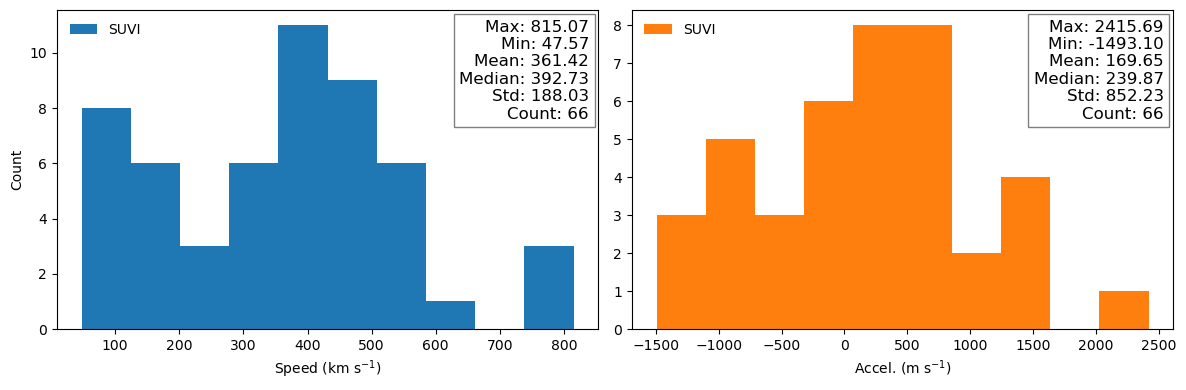

In [7]:
all_speeds_suvi  = []
all_accels_suvi  = []
all_times_suvi   = []
all_dists_suvi   = []
for file in suvi_filenames:
    df = pd.read_csv(file)
    df['speed_diff'] = df['speed_km_s'].diff()
    # calculate the Accel. in m/s2
    df['accel_m_s2'] = (df['speed_diff']*1e3) / df['time_diff_s']
    # store all speed and accels.
    all_speeds_suvi.append(df['speed_km_s'].values)
    all_accels_suvi.append(df['accel_m_s2'].values)
    all_times_suvi.append(df['time'].values)
    all_dists_suvi.append(df['distance_km'].values/sun_radius_km)
    # print(f"Max: {np.nanmax(df['distance_km'].values/sun_radius_km):.2f} Rs")
    # print(f"Min: {np.nanmin(df['distance_km'].values/sun_radius_km):.2f} Rs\n")

# Combine the 1D arrays into a single 1D array
combined_array_v = np.concatenate(all_speeds_suvi)
combined_array_a = np.concatenate(all_accels_suvi)
combined_array_t = np.concatenate(all_times_suvi)
combined_array_d = np.concatenate(all_dists_suvi)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

max_d = np.nanmax(combined_array_d)
min_d = np.nanmin(combined_array_d)
print(f"Start height: {min_d:.2f} Rs")
print(f"End height:  {max_d:.2f} Rs")

max_t = datetime.strftime(mdates.num2date(np.nanmax(combined_array_t)), '%Y-%m-%d %H:%M:%S')
min_t = datetime.strftime(mdates.num2date(np.nanmin(combined_array_t)), '%Y-%m-%d %H:%M:%S')
print(f"\nStart time: {min_t}")
print(f"End time:  {max_t}")

# Plot a histogram of the combined data
fig = plt.figure(figsize=[12,4])

ax = fig.add_subplot(121)
ax.hist(combined_array_v, bins=10, color='tab:blue', label='SUVI',
         # edgecolor='black'
        )
ax.set_xlabel(r'Speed (km s$^{-1}$)')
ax.set_ylabel('Count')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_v = f'Max: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
ax.text(0.983, 0.97, stats_text_v, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

ax = fig.add_subplot(122)
ax.hist(combined_array_a, bins=10, color='tab:orange', label='SUVI')
ax.set_xlabel(r'Accel. (m s$^{-1}$)')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_a = f'Max: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
ax.text(0.983, 0.97, stats_text_a, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()
# fig.savefig(f'{data_dir}/euv_stats_suvi.pdf', format='pdf', bbox_inches='tight')
plt.show()

Start height: 2.78 Rs
End height:  7.08 Rs

Start time: 2024-05-14 17:47:53
End time:  2024-05-14 18:24:36


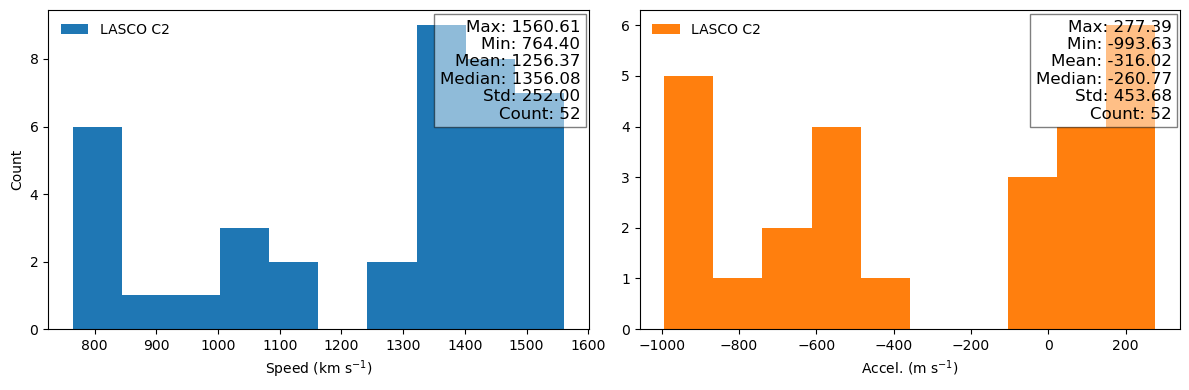

In [8]:
all_speeds_c2 = []
all_accels_c2 = []
all_times_c2  = []
all_dists_c2  = []
for file in c2_filenames:
    df = pd.read_csv(file)
    df['speed_diff'] = df['speed_km_s'].diff()
    # calculate the Accel. in m/s2
    df['accel_m_s2'] = (df['speed_diff']*1e3) / df['time_diff_s']
    # store all speed and accels.
    all_speeds_c2.append(df['speed_km_s'].values)
    all_accels_c2.append(df['accel_m_s2'].values)
    all_times_c2.append(df['time'].values)
    all_dists_c2.append(df['distance_km'].values/sun_radius_km)

# Combine the 1D arrays into a single 1D array
combined_array_v = np.concatenate(all_speeds_c2)
combined_array_a = np.concatenate(all_accels_c2)
combined_array_t = np.concatenate(all_times_c2)
combined_array_d = np.concatenate(all_dists_c2)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

max_d = np.nanmax(combined_array_d)
min_d = np.nanmin(combined_array_d)
print(f"Start height: {min_d:.2f} Rs")
print(f"End height:  {max_d:.2f} Rs")

max_t = datetime.strftime(mdates.num2date(np.nanmax(combined_array_t)), '%Y-%m-%d %H:%M:%S')
min_t = datetime.strftime(mdates.num2date(np.nanmin(combined_array_t)), '%Y-%m-%d %H:%M:%S')
print(f"\nStart time: {min_t}")
print(f"End time:  {max_t}")

# Plot a histogram of the combined data
fig = plt.figure(figsize=[12,4])

ax = fig.add_subplot(121)
ax.hist(combined_array_v, bins=10, color='tab:blue', label='LASCO C2',
         # edgecolor='black'
        )
ax.set_xlabel(r'Speed (km s$^{-1}$)')
ax.set_ylabel('Count')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_v = f'Max: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
ax.text(0.985, 0.97, stats_text_v, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

ax = fig.add_subplot(122)
ax.hist(combined_array_a, bins=10, color='tab:orange', label='LASCO C2')
ax.set_xlabel(r'Accel. (m s$^{-1}$)')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_a = f'Max: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
ax.text(0.985, 0.97, stats_text_a, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()
# fig.savefig(f'{data_dir}/euv_stats_c2.pdf', format='pdf', bbox_inches='tight')
plt.show()

Start height: 4.00 Rs
End height:  30.55 Rs

Start time: 2024-05-14 17:53:52
End time:  2024-05-14 23:01:39


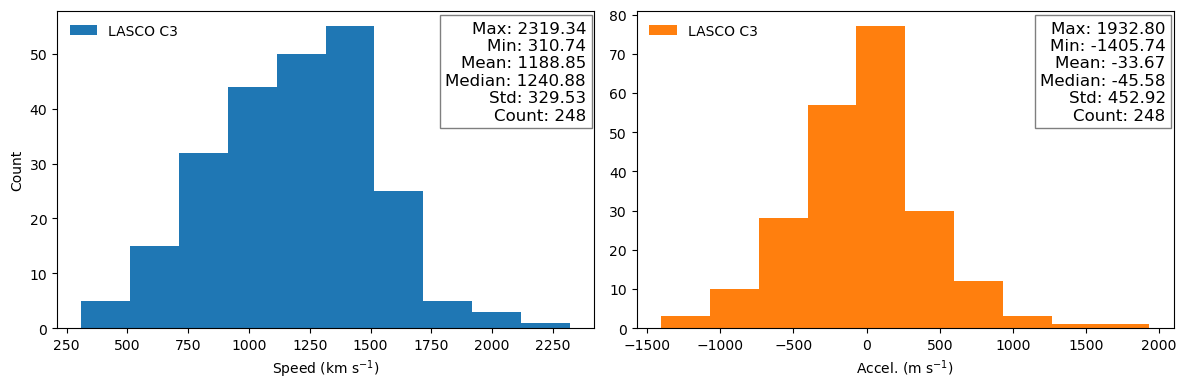

In [9]:
all_speeds_c3 = []
all_accels_c3 = []
all_times_c3  = []
all_dists_c3  = []
for file in c3_filenames:
    df = pd.read_csv(file)
    df['speed_diff'] = df['speed_km_s'].diff()
    # calculate the Accel. in m/s2
    df['accel_m_s2'] = (df['speed_diff']*1e3) / df['time_diff_s']
    # store all speed and accels.
    all_speeds_c3.append(df['speed_km_s'].values)
    all_accels_c3.append(df['accel_m_s2'].values)
    all_times_c3.append(df['time'].values)
    all_dists_c3.append(df['distance_km'].values/sun_radius_km)

# Combine the 1D arrays into a single 1D array
combined_array_v = np.concatenate(all_speeds_c3)
combined_array_a = np.concatenate(all_accels_c3)
combined_array_t = np.concatenate(all_times_c3)
combined_array_d = np.concatenate(all_dists_c3)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

max_d = np.nanmax(combined_array_d)
min_d = np.nanmin(combined_array_d)
print(f"Start height: {min_d:.2f} Rs")
print(f"End height:  {max_d:.2f} Rs")

max_t = datetime.strftime(mdates.num2date(np.nanmax(combined_array_t)), '%Y-%m-%d %H:%M:%S')
min_t = datetime.strftime(mdates.num2date(np.nanmin(combined_array_t)), '%Y-%m-%d %H:%M:%S')
print(f"\nStart time: {min_t}")
print(f"End time:  {max_t}")

# Plot a histogram of the combined data
fig = plt.figure(figsize=[12,4])

ax = fig.add_subplot(121)
ax.hist(combined_array_v, bins=10, color='tab:blue', label='LASCO C3')
ax.set_xlabel(r'Speed (km s$^{-1}$)')
ax.set_ylabel('Count')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_v = f'Max: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
ax.text(0.985, 0.97, stats_text_v, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

ax = fig.add_subplot(122)
ax.hist(combined_array_a, bins=10, color='tab:orange', label='LASCO C3')
ax.set_xlabel(r'Accel. (m s$^{-1}$)')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_a = f'Max: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
ax.text(0.985, 0.97, stats_text_a, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()
# fig.savefig(f'{data_dir}/euv_stats_c3.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Individual plots

Start height: 813760.93 Rs
End height:  1337534.89 Rs

Start time: 2024-05-14 17:12:35
End time:  2024-05-14 17:37:02


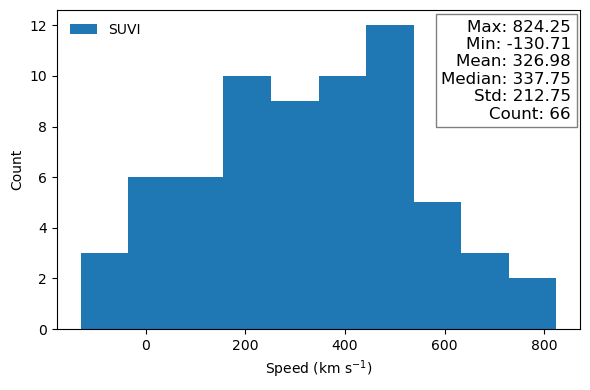

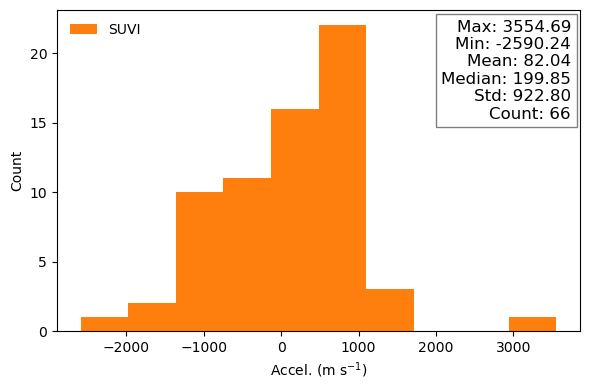

In [10]:
all_times_suvi   = []
all_dists_suvi   = []
all_speeds_suvi  = []
all_accels_suvi  = []

for file in suvi_filenames:
    df = pd.read_csv(file)
    # calc speed via savgol filter, in km/s
    x = df['time']
    y = df['distance_km']
    all_times_suvi.append(x)
    all_dists_suvi.append(y)
    # fix the time (in seconds) and distance (in km)
    xtimes = np.array([mdates.num2date(date) for date in x])
    mean_dt = np.mean([x.total_seconds() for x in np.diff(xtimes)]) # because the time spacing is not equal
    # print(mean_dt)
    # print(y)
    # if len(y) < 5:
    #     window_size = 3
    # else:
    #     window_size = 5
    window_size = 3
    speed = savgol_filter(y, window_length=window_size, polyorder=2, deriv=1, delta=mean_dt)
    all_speeds_suvi.append(speed)
    # calc accel via savgol filter, in m/s2
    accel = savgol_filter(speed*1e3, window_length=window_size, polyorder=2, deriv=1, delta=mean_dt)
    all_accels_suvi.append(accel)

# Combine the 1D arrays into a single 1D array
combined_array_v = np.concatenate(all_speeds_suvi)
combined_array_a = np.concatenate(all_accels_suvi)
combined_array_t = np.concatenate(all_times_suvi)
combined_array_d = np.concatenate(all_dists_suvi)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

max_d = np.nanmax(combined_array_d)
min_d = np.nanmin(combined_array_d)
print(f"Start height: {min_d:.2f} Rs")
print(f"End height:  {max_d:.2f} Rs")

max_t = datetime.strftime(mdates.num2date(np.nanmax(combined_array_t)), '%Y-%m-%d %H:%M:%S')
min_t = datetime.strftime(mdates.num2date(np.nanmin(combined_array_t)), '%Y-%m-%d %H:%M:%S')
print(f"\nStart time: {min_t}")
print(f"End time:  {max_t}")

# Plot a histogram of the combined data
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
ax.hist(combined_array_v, bins=10, color='tab:blue', label='SUVI')
ax.set_xlabel(r'Speed (km s$^{-1}$)')
ax.set_ylabel('Count')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_v = f'Max: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
ax.text(0.983, 0.97, stats_text_v, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
fig.tight_layout()
# fig.savefig(f'{data_dir}/euv_stats_speed_suvi.pdf', format='pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
ax.hist(combined_array_a, bins=10, color='tab:orange', label='SUVI')
ax.set_xlabel(r'Accel. (m s$^{-1}$)')
ax.set_ylabel('Count')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_a = f'Max: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
ax.text(0.983, 0.97, stats_text_a, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
fig.tight_layout()
# fig.savefig(f'{data_dir}/euv_stats_accel_suvi.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Apply Kinematics-based Model

The position $s(t)$ is modeled as: $s(t) = s_0 + v_0 \cdot t + \frac{1}{2} a \cdot t^2$ 
to estimate initial position $s_0$ initial velocity $v_0$, and acceleration $a$.

* Numerical differening does not work well.
* Savitsky-Golar filter did not perform well because of the few number points.

In [41]:
from scipy.optimize import curve_fit

def kinematic_model(t, s0, v0, a):
    """
    Define the kinematics model (position as a function of time).
    Add guess 
    """
    return s0 + v0*t + 0.5*a*t**2


def fit_kinematics(time, distance, d1=1, d2=30):
    """
    Fit data and extract kinematic parameters.
    d1: initial distance guess (e.g., 1 Rsun).
    d2: last distance guess (e.g., 30 Rsun).
    """
    # initial distance
    s0 = d1*const.radius.to('Mm').value # 4 Rsun
    s0_bounds = [const.radius.to('Mm').value, d2*const.radius.to('Mm').value] # e.g., 1 Rsun to 30 Rsun (max FOV of LASCO C3)
    # initial velocity, values given in km/s and converted to Mm/s
    v0 = 1000/1e3
    v0_bounds = [100/1e3, 2000/1e3]
    # acceleration, values given in m/s2 and converted to Mm/s2
    a = 500/1e6
    a_bounds = [-1000/1e6, 1000/1e6]
    # first guess
    init_param = [s0, v0, a]
    
    # Fit the model to the data
    params, pcov = curve_fit(kinematic_model, time, distance, p0=init_param,
                             bounds=((s0_bounds[0], v0_bounds[0], a_bounds[0]), # min constrains
                                     (s0_bounds[1], v0_bounds[1], a_bounds[1])) # max constrains
                            )
    s0, v0, a = params
    perr = np.sqrt(np.diag(pcov))
    init_pos_err, init_vel_err, a_err = perr
    
    # Calculate fitted distance, velocity, and acceleration
    fitted_distance = kinematic_model(time, s0, v0, a)
    velocity = v0 + a*time  # Instantaneous velocity (at each time point) over time
    acceleration = np.full_like(time, a)  # Constant acceleration

    # Compute velocity error propagation
    velocity_err = np.sqrt(init_vel_err**2 + (time * a_err)**2)
    
    # # Convert velocity to km/s and acceleration to m/s²
    # velocity_km_s     = velocity * 1e3  # 1 Mm/s = 1000 km/s
    # acceleration_m_s2 = acceleration * 1e6  # 1 Mm/s² = 1,000,000 m/s²

    # print(init_pos_err, init_vel_err, a_err)
    
    return (fitted_distance, velocity, velocity_err, acceleration, s0, v0, a, init_pos_err, init_vel_err, a_err)

In [12]:
# # calculate Chi-Squared values
# chisq_gallagher = sum((model - height)**2 / height)

In [13]:
# time_array = np.array([mdates.num2date(xtime) for xtime in x])
# dt = time_array - time_array[0]
# dt[0].total_seconds()

In [14]:
# time_array = np.array([mdates.num2date(xtime) for xtime in x], dtype='datetime64[ms]')  # Use milliseconds for precision
# # Convert datetime array to seconds starting from zero
# time = (time_array - time_array[0]) / np.timedelta64(1, 's')  # Convert to seconds
# time

In [15]:
# time_array = np.array([mdates.num2date(xtime) for xtime in x]), dtype='datetime64[ms]')  # Use milliseconds for precision
# # Convert datetime array to seconds starting from zero
# time = (time_array - time_array[0]) / np.timedelta64(1, 's')  # Convert to seconds

# # Apply the fit to each segment
# fitted, velocity, acceleration, s0, v0, a, init_pos_err, init_vel_err, a_err = fit_kinematics(time, y_Mm)

# # Calculate upper and lower bounds using parameter errors
# fitted_distance_upper = kinematic_model(time, s0+init_pos_err, v0+init_vel_err, a+a_err)
# fitted_distance_lower = kinematic_model(time, s0-init_pos_err, v0-init_vel_err, a-a_err)

# # Convert units to desired formats
# velocity *= 1_000             # Convert velocity from Mm/s to km/s
# v0 *= 1_000                   # Convert velocity from Mm/s to km/s
# init_vel_err *= 1_000         # Convert velocity error from Mm/s to km/s
# a *= 1_000                    # Convert acceleration from Mm/s² to km/s²
# a_err *= 1_000                # Convert acceleration error from Mm/s² to km/s²

# # Estimate velocities
# t_start = time[0]
# t_end   = time[-1]

# # Minimum velocity (at t_start)
# v_min = v0 + a*t_start
# v_min_err = np.sqrt(init_vel_err**2 + (t_start*a_err)**2)

# # Maximum velocity (at t_end)
# v_max = v0 + a*t_end
# v_max_err = np.sqrt(init_vel_err**2 + (t_end*a_err)**2)

# # Mean velocity (average of v_min and v_max)
# v_mean = (v_min + v_max) / 2
# # v_mean = np.nanmean(velocity*1e3)
# v_mean_err = 0.5 * np.sqrt(v_min_err**2 + v_max_err**2)

# # Convert units to desired formats
# a *= 1_000                    # Convert acceleration from km/s² to m/s²
# a_err *= 1_000                # Convert acceleration error from km/s² to m/s²



#     plt.plot(time, y_Mm, 'o', label='Data', markersize=4)
#     plt.plot(time, fitted, '-', label=f'Kinematic fit \n $<v>=${np.nanmean(velocity):.2f} km/s \nAccel.={a:.2f} m/s$^2$')
#     # Plot error bounds as shaded area
#     plt.fill_between(time, fitted_distance_lower, fitted_distance_upper, color='gray', alpha=0.3, label='Fit uncertainty')
#     plt.xlabel('Time (seconds)')
#     plt.ylabel('Distance (Mm)')
#     plt.title(f'Kinematics Fit for Segment {segment}')
    
#     # Output the fitted parameters for one segment
#     print(f'Segment {segment}: Initial Position (s0) = {s0:.2f} Mm, Initial Velocity (v0) = {v0:.2f} km/s, Acceleration (a) = {a:.2f} m/s^2')
#     print(f'Distance mean uncertainity: {np.nanmean(fitted_distance_upper-fitted_distance_lower):.2f} Mm\n')

## For SUVI

a: 0.0004772381969793891
s0_err: 20.39309609847758
v0_err: 0.10015421088915523
a_err: 0.00019904392685475206
a: -0.0005497430403396231
s0_err: 9.425781591550244
v0_err: 0.06276108654842479
a_err: 0.00016554366240434308
a: 8.831121292307713e-05
s0_err: 15.384771082307276
v0_err: 0.1014083354327631
a_err: 0.0002656612777987989
a: 0.00035929189837765024
s0_err: 21.54698280503396
v0_err: 0.08010668672325344
a_err: 0.00012410761506677443
a: 0.00032229105661361277
s0_err: 13.350304319054459
v0_err: 0.05108378121080062
a_err: 8.08402387215178e-05
a: 0.00022272302651235603
s0_err: 34.75032794475356
v0_err: 0.1373591772123035
a_err: 0.000219633235391912
a: 0.00021142030144762137
s0_err: 26.850429689301215
v0_err: 0.08672175554922198
a_err: 0.00011465810613990589
a: 0.00015143847310948315
s0_err: 21.854990683042587
v0_err: 0.08429652459350956
a_err: 0.0001329675174184678
a: 0.00018741718961938467
s0_err: 23.32368330780172
v0_err: 0.11421513432510808
a_err: 0.0002262086727116731
a: 0.000256423780

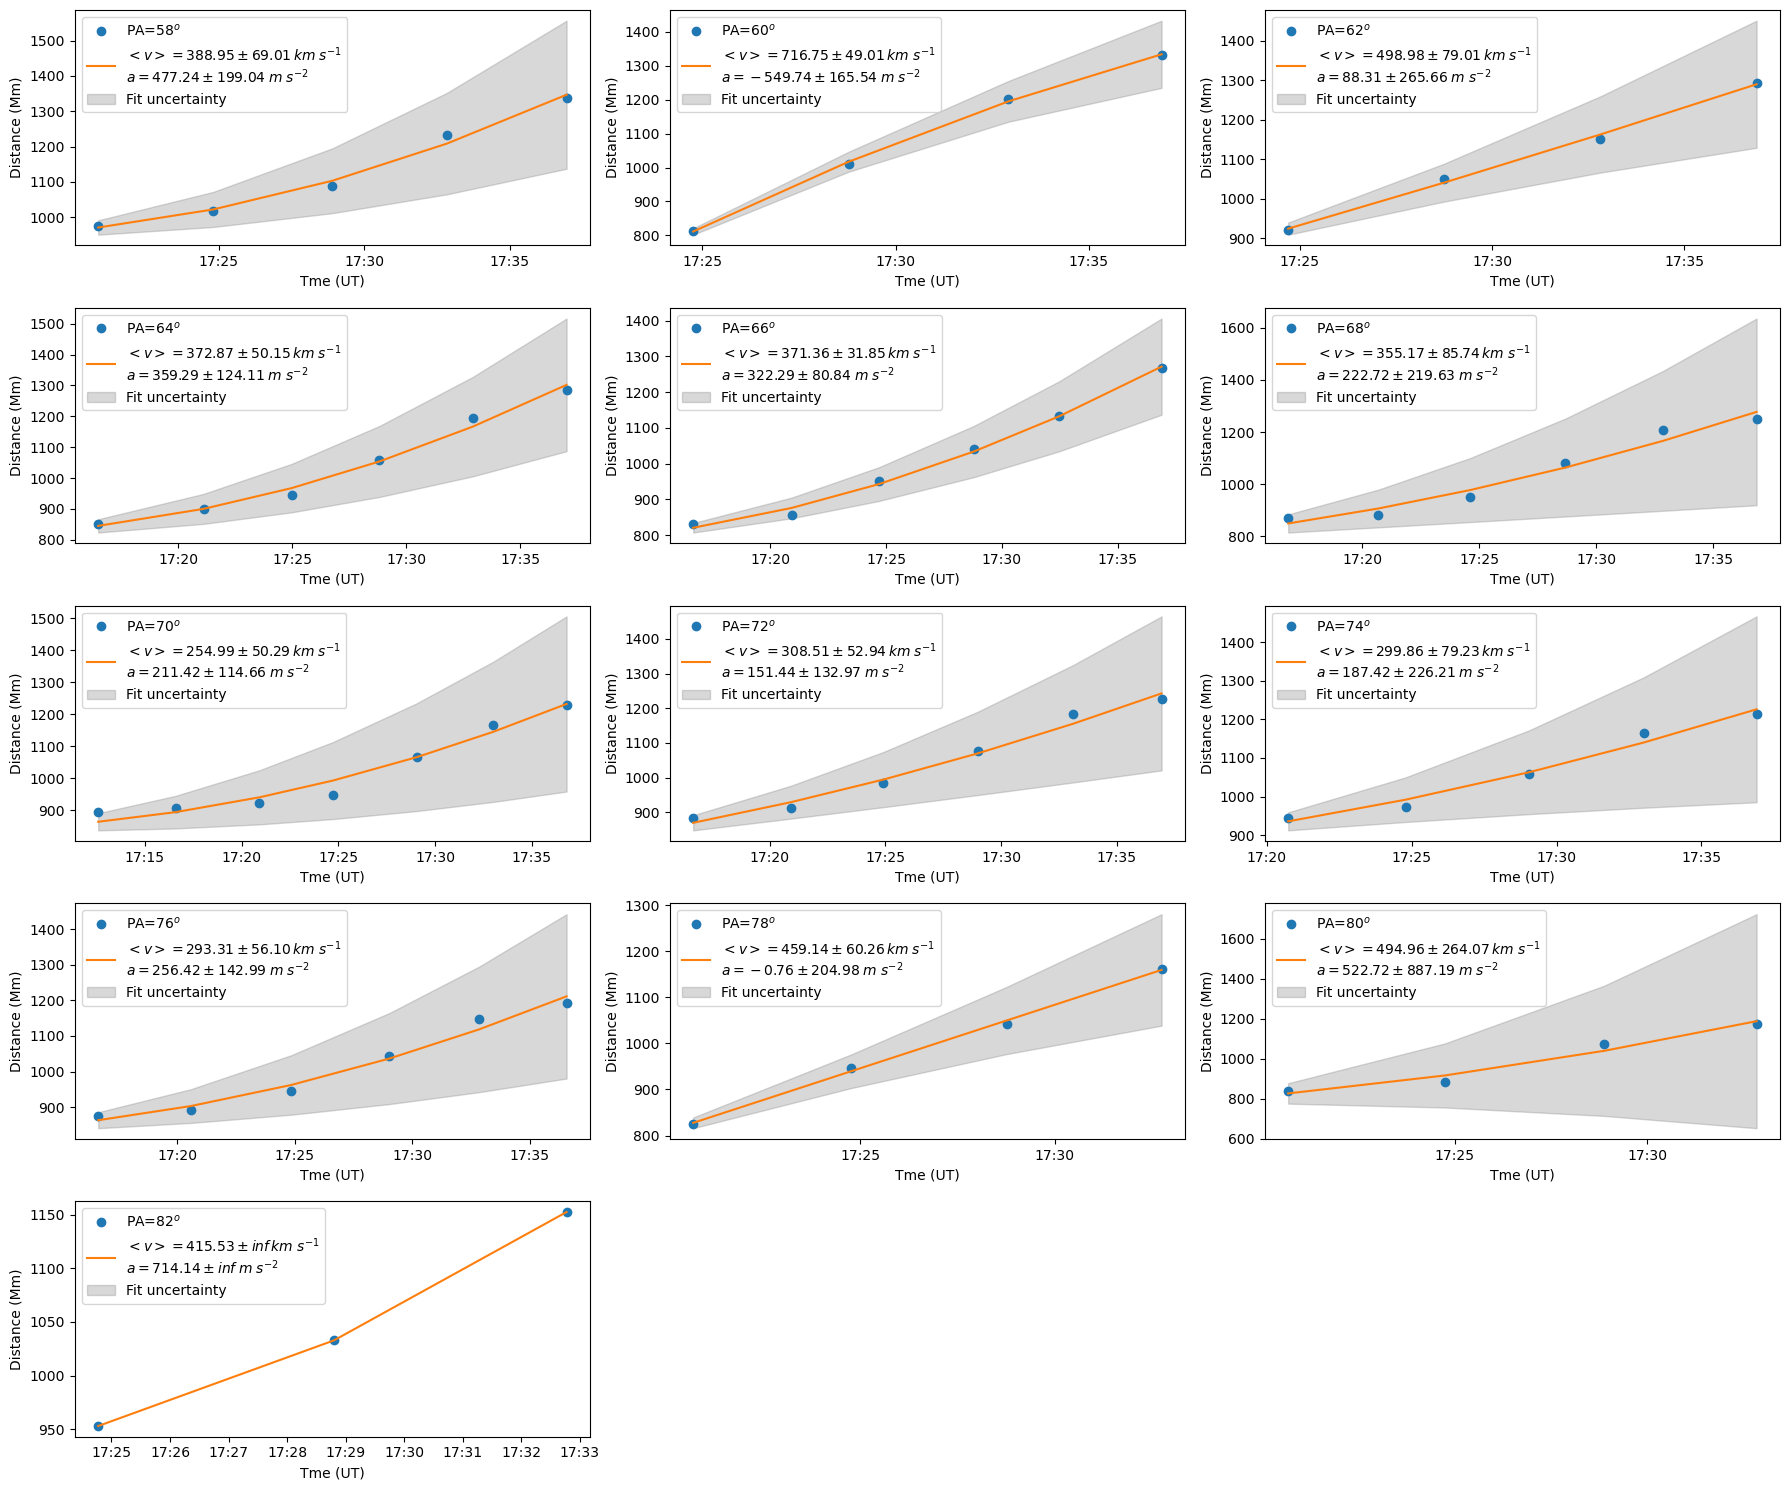

In [43]:
# suvi_filenames, c2_filenames, c3_filenames
instrument_files = suvi_filenames

# Initialize an empty list to store results
fit_results_suvi = []
all_times_suvi = []
all_speeds_km_s_suvi = []
all_accels_m_s2_suvi = []
all_fit_dist_Mm_suvi = []

num_files = len(instrument_files)
cols = 3  # Number of columns in the figure
rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
bins = 10
fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))  # Make a grid of subplots
axes = axes.flatten()  # Flatten in case of a 2D array of axes

for i, file in enumerate(instrument_files):
    df = pd.read_csv(file)
    
    angle = file.split('_')[-1][:-4]
    # rename the angles to be position angles, instead of geometric angles
    PA_value = int(angle) - 90
    
    # calc speed via savgol filter, in km/s
    x = df['time']
    y = df['distance_km']
    y_Mm = [(y_km*u.km).to('Mm').value for y_km in y]
    
    # apply the kinematic fit
    # ========================
    time_array = np.array([mdates.num2date(xtime) for xtime in x], dtype='datetime64[ms]')  # Use milliseconds for precision
    # Convert datetime array to seconds starting from zero
    time = (time_array - time_array[0]) / np.timedelta64(1, 's')  # Convert to seconds
    
    # Apply the fit to each segment
    fitted, velocity, velocity_err, acceleration, s0, v0, a, init_pos_err, init_vel_err, a_err = fit_kinematics(time, y_Mm, d1=1, d2=2)
    print(f'a: {a}')
    print(f's0_err: {init_pos_err}')
    print(f'v0_err: {init_vel_err}')
    print(f'a_err: {a_err}')
    
    # Calculate upper and lower bounds using parameter errors
    fitted_distance_upper = kinematic_model(time, s0+init_pos_err, v0+init_vel_err, a+a_err)
    fitted_distance_lower = kinematic_model(time, s0-init_pos_err, v0-init_vel_err, a-a_err)
    
    # Convert units to desired formats
    velocity     *= 1_000         # Convert velocity from Mm/s to km/s
    velocity_err *= 1_000         # Convert velocity from Mm/s to km/s
    v0           *= 1_000         # Convert velocity from Mm/s to km/s
    init_vel_err *= 1_000         # Convert velocity error from Mm/s to km/s
    a     *= 1_000                # Convert acceleration from Mm/s² to km/s²
    a_err *= 1_000                # Convert acceleration error from Mm/s² to km/s²
    
    # Estimate velocities
    t_start = time[0]
    t_end   = time[-1]
    
    # Minimum velocity (at t_start)
    v_min     = v0 + a*t_start
    v_min_err = np.sqrt(init_vel_err**2 + (t_start*a_err)**2)
    
    # Maximum velocity (at t_end)
    v_max     = v0 + a*t_end
    v_max_err = np.sqrt(init_vel_err**2 + (t_end*a_err)**2)
    
    # Mean velocity (average of v_min and v_max)
    # v_mean = (v_min + v_max) / 2
    # v_mean_err = 0.5 * np.sqrt(v_min_err**2 + v_max_err**2)
    v_mean     = np.nanmean(velocity)
    v_mean_err = np.sqrt(np.nansum(velocity_err**2)) / len(velocity)
    
    # Convert units to desired formats
    a     *= 1_000                # Convert acceleration from km/s² to m/s²
    a_err *= 1_000                # Convert acceleration error from km/s² to m/s²
    acceleration *= 1_000_000     # Convert acceleration from Mm/s² to m/s²
    
    # store all speed and accels. --> Why am I doing this? --> To get the overall distribution of each variable
    all_times_suvi.append(time_array)
    all_speeds_km_s_suvi.append(velocity)
    all_accels_m_s2_suvi.append(acceleration)
    all_fit_dist_Mm_suvi.append(fitted)
    
    # Store results as a dictionary
    fit_results_suvi.append({
        'PA': PA_value,
        's0_Mm': s0,
        'v0_km/s': v0,
        'a_m/s2': a,
        'v_min_km/s': v_min,
        'v_max_km/s': v_max,
        'v_mean_km/s': v_mean,
        'init_pos_err_Mm': init_pos_err,
        'init_vel_err_km/s': init_vel_err,
        'a_err_m/s2': a_err,
        'v_min_err_km/s': v_min_err,
        'v_max_err_km/s': v_max_err,
        'v_mean_err_km/s': v_mean_err
    })
    
    ax = axes[i]  # Use the i-th subplot
    ax.plot(x, y_Mm, 'o', label=rf'PA={PA_value}$^o$')
    ax.plot(x, fitted, '-', label=rf'$<v>={v_mean:.2f} \pm {v_mean_err:.2f} \, km \; s^{{-1}}$' '\n' 
                            rf'$a={a:.2f} \pm {a_err:.2f} \; m \; s^{{-2}}$')
    # Plot error bounds as shaded area
    ax.fill_between(x, fitted_distance_lower, fitted_distance_upper, color='gray', alpha=0.3, label='Fit uncertainty')
    ax.set_ylabel('Distance (Mm)')
    ax.set_xlabel('Tme (UT)')
    ax.legend(loc='best')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Output the fitted parameters for one segment
    # print(f'Slit {PA_value}: Initial Position (s0) = {s0:.2f} Mm, Initial Velocity (v0) = {v0:.2f} km/s, Acceleration (a) = {a:.2f} m/s^2')
    # print(f'Distance mean uncertainity: {np.nanmean(fitted_distance_upper-fitted_distance_lower):.2f} Mm\n')

# Hide unused subplots if `num_files` is not a multiple of `cols`
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Convert list to DataFrame
fit_df_suvi = pd.DataFrame(fit_results_suvi)
fit_df_suvi = fit_df_suvi.applymap(lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else x)
# Ensure fit_df stays numeric
fit_df_suvi = fit_df_suvi.astype(float)  # Convert all numeric columns back to floats

fig.tight_layout()
plt.show()

In [44]:
fit_df_suvi

,PA,s0_Mm,v0_km/s,a_m/s2,v_min_km/s,v_max_km/s,v_mean_km/s,init_pos_err_Mm,init_vel_err_km/s,a_err_m/s2,v_min_err_km/s,v_max_err_km/s,v_mean_err_km/s
0,58.0,970.35,159.37,477.24,159.37,620.26,388.95,20.39,100.15,199.04,100.15,216.75,69.01
1,60.0,811.58,917.20,-549.74,917.20,517.30,716.75,9.43,62.76,165.54,62.76,135.80,49.01
2,62.0,924.56,466.69,88.31,466.69,531.30,498.98,15.38,101.41,265.66,101.41,219.23,79.01
3,64.0,845.36,148.52,359.29,148.52,591.63,372.87,21.55,80.11,124.11,80.11,172.76,50.15
4,66.0,820.43,176.78,322.29,176.78,567.52,371.36,13.35,51.08,80.84,51.08,110.52,31.85
5,68.0,849.67,222.66,222.72,222.66,490.05,355.17,34.75,137.36,219.63,137.36,297.31,85.74
6,70.0,864.15,100.00,211.42,100.00,407.00,254.99,26.85,86.72,114.66,86.72,187.72,50.29
7,72.0,869.40,215.54,151.44,215.54,399.46,308.51,21.85,84.30,132.97,84.30,182.16,52.94
8,74.0,935.72,208.06,187.42,208.06,389.97,299.86,23.32,114.22,226.21,114.22,247.49,79.23
9,76.0,863.39,137.72,256.42,137.72,444.32,293.31,22.43,88.83,142.99,88.83,192.67,56.10


In [45]:
# Type II burst lanes with their radial velocities
type_II_bursts = [
    ('1 LF', 1227.51), ('1 LH', 1224.16), ('1 UF', 546.37), ('1 UH', 632.60),
    ('2 F', 810.06), ('2 H', 816.65), ('3 LF', 553.15), ('3 LH', 709.25),
    ('3 MF', 443.09), ('3 MH', 480.89), ('3 UF', 497.91), ('3 UH', 568.12),
    ('4 F', 1939.38), ('4 H', 2075.31)
]

# CME fitted results
CME_fit_data = fit_df_suvi[['PA','v0_km/s','v_min_km/s','v_max_km/s','v_mean_km/s']]

# Find the closest PA for each Type II burst lane
results = []
for lane, radial_velocity in type_II_bursts:
    closest_idx = (CME_fit_data['v_mean_km/s'] - radial_velocity).abs().idxmin()
    closest_pa = CME_fit_data.loc[closest_idx, 'PA']
    closest_v_mean = CME_fit_data.loc[closest_idx, 'v_mean_km/s']
    results.append((lane, radial_velocity, closest_pa, closest_v_mean))

# Convert results to DataFrame
match_results = pd.DataFrame(results, columns=['Type II Lane', 'Radial Velocity (km/s)', 'Closest PA', 'Closest v_mean_km/s'])
match_results

,Type II Lane,Radial Velocity (km/s),Closest PA,Closest v_mean_km/s
0,1 LF,1227.51,60.0,716.75
1,1 LH,1224.16,60.0,716.75
2,1 UF,546.37,62.0,498.98
3,1 UH,632.60,60.0,716.75
4,2 F,810.06,60.0,716.75
5,2 H,816.65,60.0,716.75
6,3 LF,553.15,62.0,498.98
7,3 LH,709.25,60.0,716.75
8,3 MF,443.09,78.0,459.14
9,3 MH,480.89,80.0,494.96


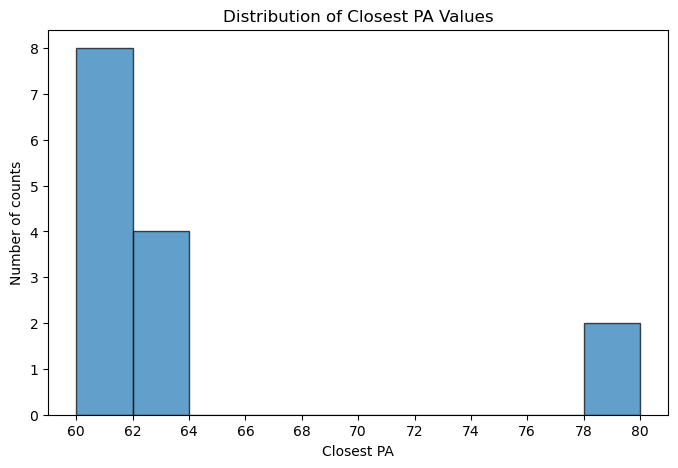

In [47]:
# Extract the closest PA values from the results DataFrame
closest_pa_values = match_results['Closest PA']

# Plot the histogram
plt.figure(figsize=(8,5))
# plt.hist(closest_pa_values, bins=range(int(min(closest_pa_values)), int(max(closest_pa_values)) + 2, 2), edgecolor='black', alpha=0.7)
plt.hist(closest_pa_values, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Closest PA')
plt.ylabel('Number of counts')
plt.title('Distribution of Closest PA Values')
plt.xticks(range(int(min(closest_pa_values)), int(max(closest_pa_values)) + 2, 2))
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [48]:
summary_suvi = fit_df_suvi[['s0_Mm', 'v0_km/s', 'a_m/s2']].agg(['min', 'max', 'mean', 'median', 'std']).round(2)
summary_suvi

,s0_Mm,v0_km/s,a_m/s2
min,811.58,100.00,-549.74
max,970.35,917.20,714.14
mean,873.94,289.14,227.92
median,863.39,215.54,222.72
std,53.85,220.15,302.32


In [49]:
# errors
fit_df_suvi[['init_pos_err_Mm', 'init_vel_err_km/s', 'a_err_m/s2']].agg(['min', 'max', 'mean', 'median', 'std']).round(2)

,init_pos_err_Mm,init_vel_err_km/s,a_err_m/s2
min,9.43,51.08,80.84
max,inf,inf,inf
mean,inf,inf,inf
median,21.85,88.83,199.04
std,NaN,NaN,NaN


In [50]:
# Replace 'inf' values with NaN
fit_df_suvi.replace([np.inf, -np.inf], np.nan, inplace=True)
fit_df_suvi

,PA,s0_Mm,v0_km/s,a_m/s2,v_min_km/s,v_max_km/s,v_mean_km/s,init_pos_err_Mm,init_vel_err_km/s,a_err_m/s2,v_min_err_km/s,v_max_err_km/s,v_mean_err_km/s
0,58.0,970.35,159.37,477.24,159.37,620.26,388.95,20.39,100.15,199.04,100.15,216.75,69.01
1,60.0,811.58,917.20,-549.74,917.20,517.30,716.75,9.43,62.76,165.54,62.76,135.80,49.01
2,62.0,924.56,466.69,88.31,466.69,531.30,498.98,15.38,101.41,265.66,101.41,219.23,79.01
3,64.0,845.36,148.52,359.29,148.52,591.63,372.87,21.55,80.11,124.11,80.11,172.76,50.15
4,66.0,820.43,176.78,322.29,176.78,567.52,371.36,13.35,51.08,80.84,51.08,110.52,31.85
5,68.0,849.67,222.66,222.72,222.66,490.05,355.17,34.75,137.36,219.63,137.36,297.31,85.74
6,70.0,864.15,100.00,211.42,100.00,407.00,254.99,26.85,86.72,114.66,86.72,187.72,50.29
7,72.0,869.40,215.54,151.44,215.54,399.46,308.51,21.85,84.30,132.97,84.30,182.16,52.94
8,74.0,935.72,208.06,187.42,208.06,389.97,299.86,23.32,114.22,226.21,114.22,247.49,79.23
9,76.0,863.39,137.72,256.42,137.72,444.32,293.31,22.43,88.83,142.99,88.83,192.67,56.10


In [52]:
# Compute statistics while ignoring NaN values
stats_suvi = fit_df_suvi[['init_pos_err_Mm', 'init_vel_err_km/s', 'a_err_m/s2']].agg(['min', 'max', 'mean', 'median', 'std']).round(2)
stats_suvi

,init_pos_err_Mm,init_vel_err_km/s,a_err_m/s2
min,9.43,51.08,80.84
max,51.06,337.85,887.19
mean,22.66,110.17,230.32
median,21.70,87.78,182.29
std,11.34,75.18,213.79


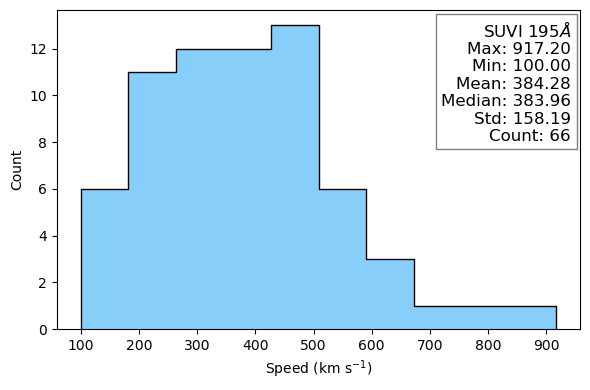

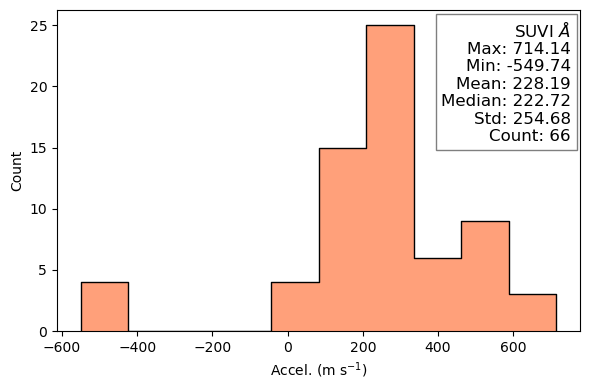

In [53]:
combined_array_v = np.concatenate(all_speeds_km_s_suvi)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

# Plot a histogram of the combined data
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(combined_array_v, bins=10, color='lightskyblue', label='SUVI')
# Construct the outline around the histogram
outline_x = np.repeat(bins, 2)[1:-1]  # Duplicate bin edges for step-like connection
outline_y = np.repeat(n, 2)  # Duplicate counts for step-like outline
# Add starting and ending points to close the outline
outline_x = np.concatenate(([bins[0]], outline_x, [bins[-1]]))
outline_y = np.concatenate(([0], outline_y, [0]))
# Plot the outline
ax.plot(outline_x, outline_y, color='black', linewidth=1)
ax.set_xlabel(r'Speed (km s$^{-1}$)')
ax.set_ylabel('Count')
# ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_v = f'SUVI 195$\AA$\nMax: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
ax.text(0.983, 0.97, stats_text_v, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
fig.tight_layout()
fig.savefig(f'{data_dir}/euv_stats_speed_suvi.pdf', format='pdf', bbox_inches='tight')
plt.show()

# ============================================================

combined_array_a = np.concatenate(all_accels_m_s2_suvi)

# Calculate basic statistics
max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(combined_array_a, bins=10, color='lightsalmon', label='SUVI')
# Construct the outline around the histogram
outline_x = np.repeat(bins, 2)[1:-1]  # Duplicate bin edges for step-like connection
outline_y = np.repeat(n, 2)  # Duplicate counts for step-like outline
# Add starting and ending points to close the outline
outline_x = np.concatenate(([bins[0]], outline_x, [bins[-1]]))
outline_y = np.concatenate(([0], outline_y, [0]))
# Plot the outline
ax.plot(outline_x, outline_y, color='black', linewidth=1)
ax.set_xlabel(r'Accel. (m s$^{-1}$)')
ax.set_ylabel('Count')
# ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_a = f'SUVI $\AA$\nMax: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
ax.text(0.983, 0.97, stats_text_a, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
fig.tight_layout()
fig.savefig(f'{data_dir}/euv_stats_accel_suvi.pdf', format='pdf', bbox_inches='tight')
plt.show()

## For LASCO C2

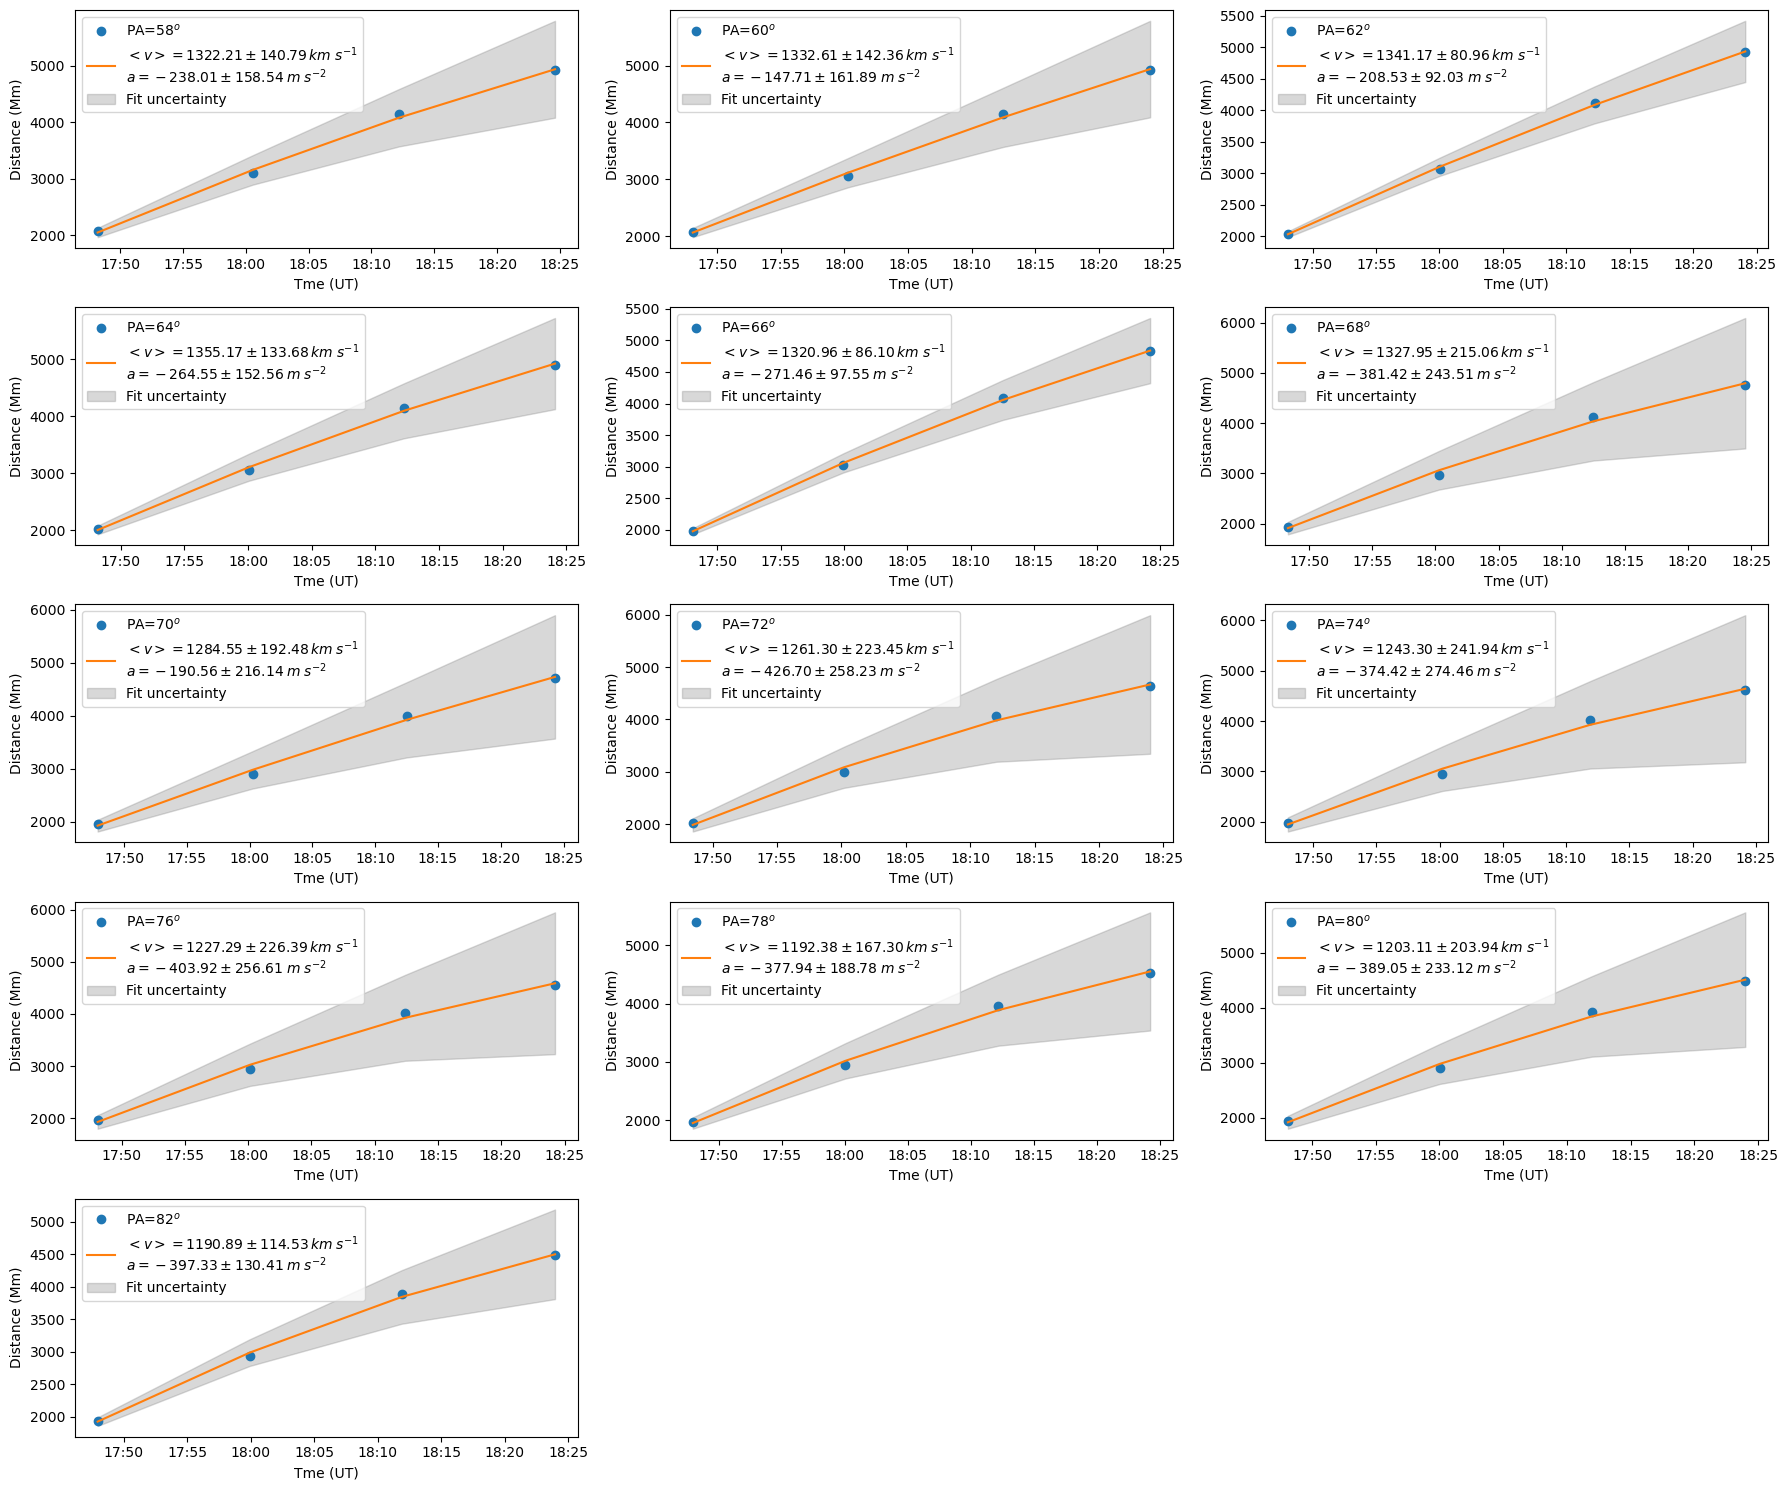

In [58]:
# suvi_filenames, c2_filenames, c3_filenames
instrument_files = c2_filenames

# Initialize empty lists to store results
fit_results_c2 = []
all_times_c2 = []
all_speeds_km_s_c2 = []
all_accels_m_s2_c2 = []
all_fit_dist_Mm_c2 = []

num_files = len(instrument_files)
cols = 3  # Number of columns in the figure
rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
bins = 10
fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))  # Make a grid of subplots
axes = axes.flatten()  # Flatten in case of a 2D array of axes

for i, file in enumerate(instrument_files):
    df = pd.read_csv(file)
    
    angle = file.split('_')[-1][:-4]
    # rename the angles to be position angles, instead of geometric angles
    PA_value = int(angle) - 90
    
    # calc speed via savgol filter, in km/s
    x = df['time']
    y = df['distance_km']
    y_Mm = [(y_km*u.km).to('Mm').value for y_km in y]
    
    # apply the kinematic fit
    # ========================
    time_array = np.array([mdates.num2date(xtime) for xtime in x], dtype='datetime64[ms]')  # Use milliseconds for precision
    # Convert datetime array to seconds starting from zero
    time = (time_array - time_array[0]) / np.timedelta64(1, 's')  # Convert to seconds
    
    # Apply the fit to each segment
    fitted, velocity, velocity_err, acceleration, s0, v0, a, init_pos_err, init_vel_err, a_err = fit_kinematics(time, y_Mm, d1=2, d2=6)
    
    # Calculate upper and lower bounds using parameter errors
    fitted_distance_upper = kinematic_model(time, s0+init_pos_err, v0+init_vel_err, a+a_err)
    fitted_distance_lower = kinematic_model(time, s0-init_pos_err, v0-init_vel_err, a-a_err)
    
    # Convert units to desired formats
    velocity     *= 1_000         # Convert velocity from Mm/s to km/s
    velocity_err *= 1_000         # Convert velocity from Mm/s to km/s
    v0           *= 1_000         # Convert velocity from Mm/s to km/s
    init_vel_err *= 1_000         # Convert velocity error from Mm/s to km/s
    a     *= 1_000                # Convert acceleration from Mm/s² to km/s²
    a_err *= 1_000                # Convert acceleration error from Mm/s² to km/s²
    
    # Estimate velocities
    t_start = time[0]
    t_end   = time[-1]
    
    # Minimum velocity (at t_start)
    v_min     = v0 + a*t_start
    v_min_err = np.sqrt(init_vel_err**2 + (t_start*a_err)**2)
    
    # Maximum velocity (at t_end)
    v_max     = v0 + a*t_end
    v_max_err = np.sqrt(init_vel_err**2 + (t_end*a_err)**2)
    
    # Mean velocity (average of v_min and v_max)
    # v_mean = (v_min + v_max) / 2
    # v_mean_err = 0.5 * np.sqrt(v_min_err**2 + v_max_err**2)
    v_mean     = np.nanmean(velocity)
    v_mean_err = np.sqrt(np.nansum(velocity_err**2)) / len(velocity)
    
    # Convert units to desired formats
    a     *= 1_000                # Convert acceleration from km/s² to m/s²
    a_err *= 1_000                # Convert acceleration error from km/s² to m/s²
    acceleration *= 1_000_000     # Convert acceleration from Mm/s² to m/s²
    
    # store all speed and accels. --> Why am I doing this? --> To get the overall distribution of each variable
    all_times_c2.append(time_array)
    all_speeds_km_s_c2.append(velocity)
    all_accels_m_s2_c2.append(acceleration)
    all_fit_dist_Mm_c2.append(fitted)
    
    # Store results as a dictionary
    fit_results_c2.append({
        'PA': PA_value,
        's0_Mm': s0,
        'v0_km/s': v0,
        'a_m/s2': a,
        'v_min_km/s': v_min,
        'v_max_km/s': v_max,
        'v_mean_km/s': v_mean,
        'init_pos_err_Mm': init_pos_err,
        'init_vel_err_km/s': init_vel_err,
        'a_err_m/s2': a_err,
        'v_min_err_km/s': v_min_err,
        'v_max_err_km/s': v_max_err,
        'v_mean_err_km/s': v_mean_err
    })
    
    ax = axes[i]  # Use the i-th subplot
    ax.plot(x, y_Mm, 'o', label=rf'PA={PA_value}$^o$')
    ax.plot(x, fitted, '-', label=rf'$<v>={v_mean:.2f} \pm {v_mean_err:.2f} \, km \; s^{{-1}}$' '\n' 
                            rf'$a={a:.2f} \pm {a_err:.2f} \; m \; s^{{-2}}$')
    # Plot error bounds as shaded area
    ax.fill_between(x, fitted_distance_lower, fitted_distance_upper, color='gray', alpha=0.3, label='Fit uncertainty')
    ax.set_ylabel('Distance (Mm)')
    ax.set_xlabel('Tme (UT)')
    ax.legend(loc='best')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Output the fitted parameters for one segment
    # print(f'Slit {PA_value}: Initial Position (s0) = {s0:.2f} Mm, Initial Velocity (v0) = {v0:.2f} km/s, Acceleration (a) = {a:.2f} m/s^2')
    # print(f'Distance mean uncertainity: {np.nanmean(fitted_distance_upper-fitted_distance_lower):.2f} Mm\n')

# Hide unused subplots if `num_files` is not a multiple of `cols`
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Convert list to DataFrame
fit_df_c2 = pd.DataFrame(fit_results_c2)
fit_df_c2 = fit_df_c2.applymap(lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else x)
# Ensure fit_df stays numeric
fit_df_c2 = fit_df_c2.astype(float)  # Convert all numeric columns back to floats

fig.tight_layout()
plt.show()

In [59]:
fit_df_c2

,PA,s0_Mm,v0_km/s,a_m/s2,v_min_km/s,v_max_km/s,v_mean_km/s,init_pos_err_Mm,init_vel_err_km/s,a_err_m/s2,v_min_err_km/s,v_max_err_km/s,v_mean_err_km/s
0,58.0,2052.25,1582.11,-238.01,1582.11,1061.92,1322.21,83.00,181.03,158.54,181.03,390.94,140.79
1,60.0,2061.03,1493.37,-147.71,1493.37,1174.85,1332.61,81.23,181.74,161.89,181.74,393.58,142.36
2,62.0,2032.87,1566.94,-208.53,1566.94,1115.91,1341.17,46.42,103.79,92.03,103.79,224.49,80.96
3,64.0,2003.04,1640.29,-264.55,1640.29,1070.25,1355.17,76.32,171.42,152.56,171.42,370.75,133.68
4,66.0,1973.90,1616.17,-271.46,1616.17,1027.72,1320.96,48.97,110.12,97.55,110.12,238.42,86.10
5,68.0,1908.10,1741.97,-381.42,1741.97,913.30,1327.95,123.96,275.96,243.51,275.96,596.70,215.06
6,70.0,1922.96,1494.26,-190.56,1494.26,1077.77,1284.55,111.66,246.09,216.14,246.09,532.65,192.48
7,72.0,1985.20,1714.43,-426.70,1714.43,805.40,1261.30,126.77,287.17,258.23,287.17,620.57,223.45
8,74.0,1947.69,1649.12,-374.42,1649.12,836.87,1243.30,141.09,310.96,274.46,310.96,671.71,241.94
9,76.0,1926.46,1666.40,-403.92,1666.40,790.81,1227.29,129.98,289.93,256.61,289.93,627.28,226.39


In [60]:
summary_c2 = fit_df_c2[['s0_Mm', 'v0_km/s', 'a_m/s2']].agg(['min', 'max', 'mean', 'median', 'std']).round(2)
summary_c2

,s0_Mm,v0_km/s,a_m/s2
min,1908.10,1493.37,-426.70
max,2061.03,1741.97,-147.71
mean,1970.22,1616.19,-313.20
median,1951.35,1619.61,-374.42
std,52.75,72.67,95.60


In [61]:
# errors
fit_df_c2[['init_pos_err_Mm', 'init_vel_err_km/s','a_err_m/s2']].agg(['min', 'max', 'mean', 'median', 'std']).round(2)

,init_pos_err_Mm,init_vel_err_km/s,a_err_m/s2
min,46.42,103.79,92.03
max,141.09,310.96,274.46
mean,96.11,213.99,189.53
median,97.00,214.56,188.78
std,31.56,70.15,62.25


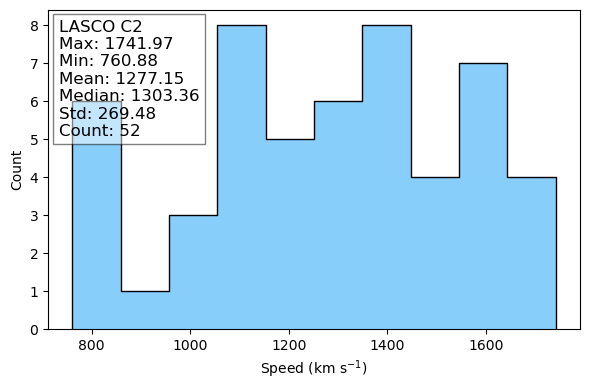

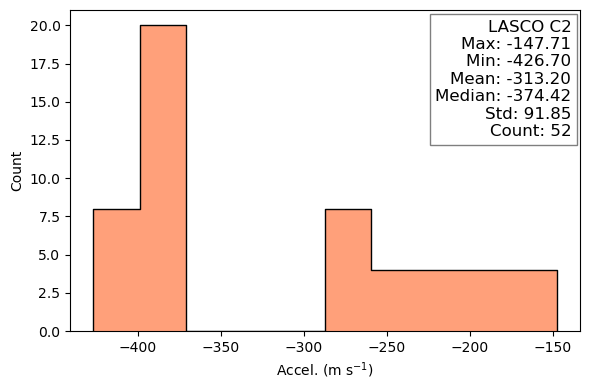

In [20]:
combined_array_v = np.concatenate(all_speeds_km_s_c2)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

# Plot a histogram of the combined data
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(combined_array_v, bins=10, color='lightskyblue', label='LASC0 C2')
# Construct the outline around the histogram
outline_x = np.repeat(bins, 2)[1:-1]  # Duplicate bin edges for step-like connection
outline_y = np.repeat(n, 2)  # Duplicate counts for step-like outline
# Add starting and ending points to close the outline
outline_x = np.concatenate(([bins[0]], outline_x, [bins[-1]]))
outline_y = np.concatenate(([0], outline_y, [0]))
# Plot the outline
ax.plot(outline_x, outline_y, color='black', linewidth=1)
ax.set_xlabel(r'Speed (km s$^{-1}$)')
ax.set_ylabel('Count')
# Add statistics to the top-right corner of the plot
stats_text_v = f'LASCO C2\nMax: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
ax.text(0.02, 0.97, stats_text_v, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))
fig.tight_layout()
# fig.savefig(f'{data_dir}/euv_stats_speed_c2.pdf', format='pdf', bbox_inches='tight')
plt.show()

# ============================================================

combined_array_a = np.concatenate(all_accels_m_s2_c2)

# Calculate basic statistics
max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(combined_array_a, bins=10, color='lightsalmon', label='LASCO C2')
# Construct the outline around the histogram
outline_x = np.repeat(bins, 2)[1:-1]  # Duplicate bin edges for step-like connection
outline_y = np.repeat(n, 2)  # Duplicate counts for step-like outline
# Add starting and ending points to close the outline
outline_x = np.concatenate(([bins[0]], outline_x, [bins[-1]]))
outline_y = np.concatenate(([0], outline_y, [0]))
# Plot the outline
ax.plot(outline_x, outline_y, color='black', linewidth=1)
ax.set_xlabel(r'Accel. (m s$^{-1}$)')
ax.set_ylabel('Count')
# Add statistics to the top-right corner of the plot
stats_text_a = f'LASCO C2\nMax: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
ax.text(0.983, 0.97, stats_text_a, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
fig.tight_layout()
# fig.savefig(f'{data_dir}/euv_stats_accel_c2.pdf', format='pdf', bbox_inches='tight')
plt.show()

## For LASCO C3

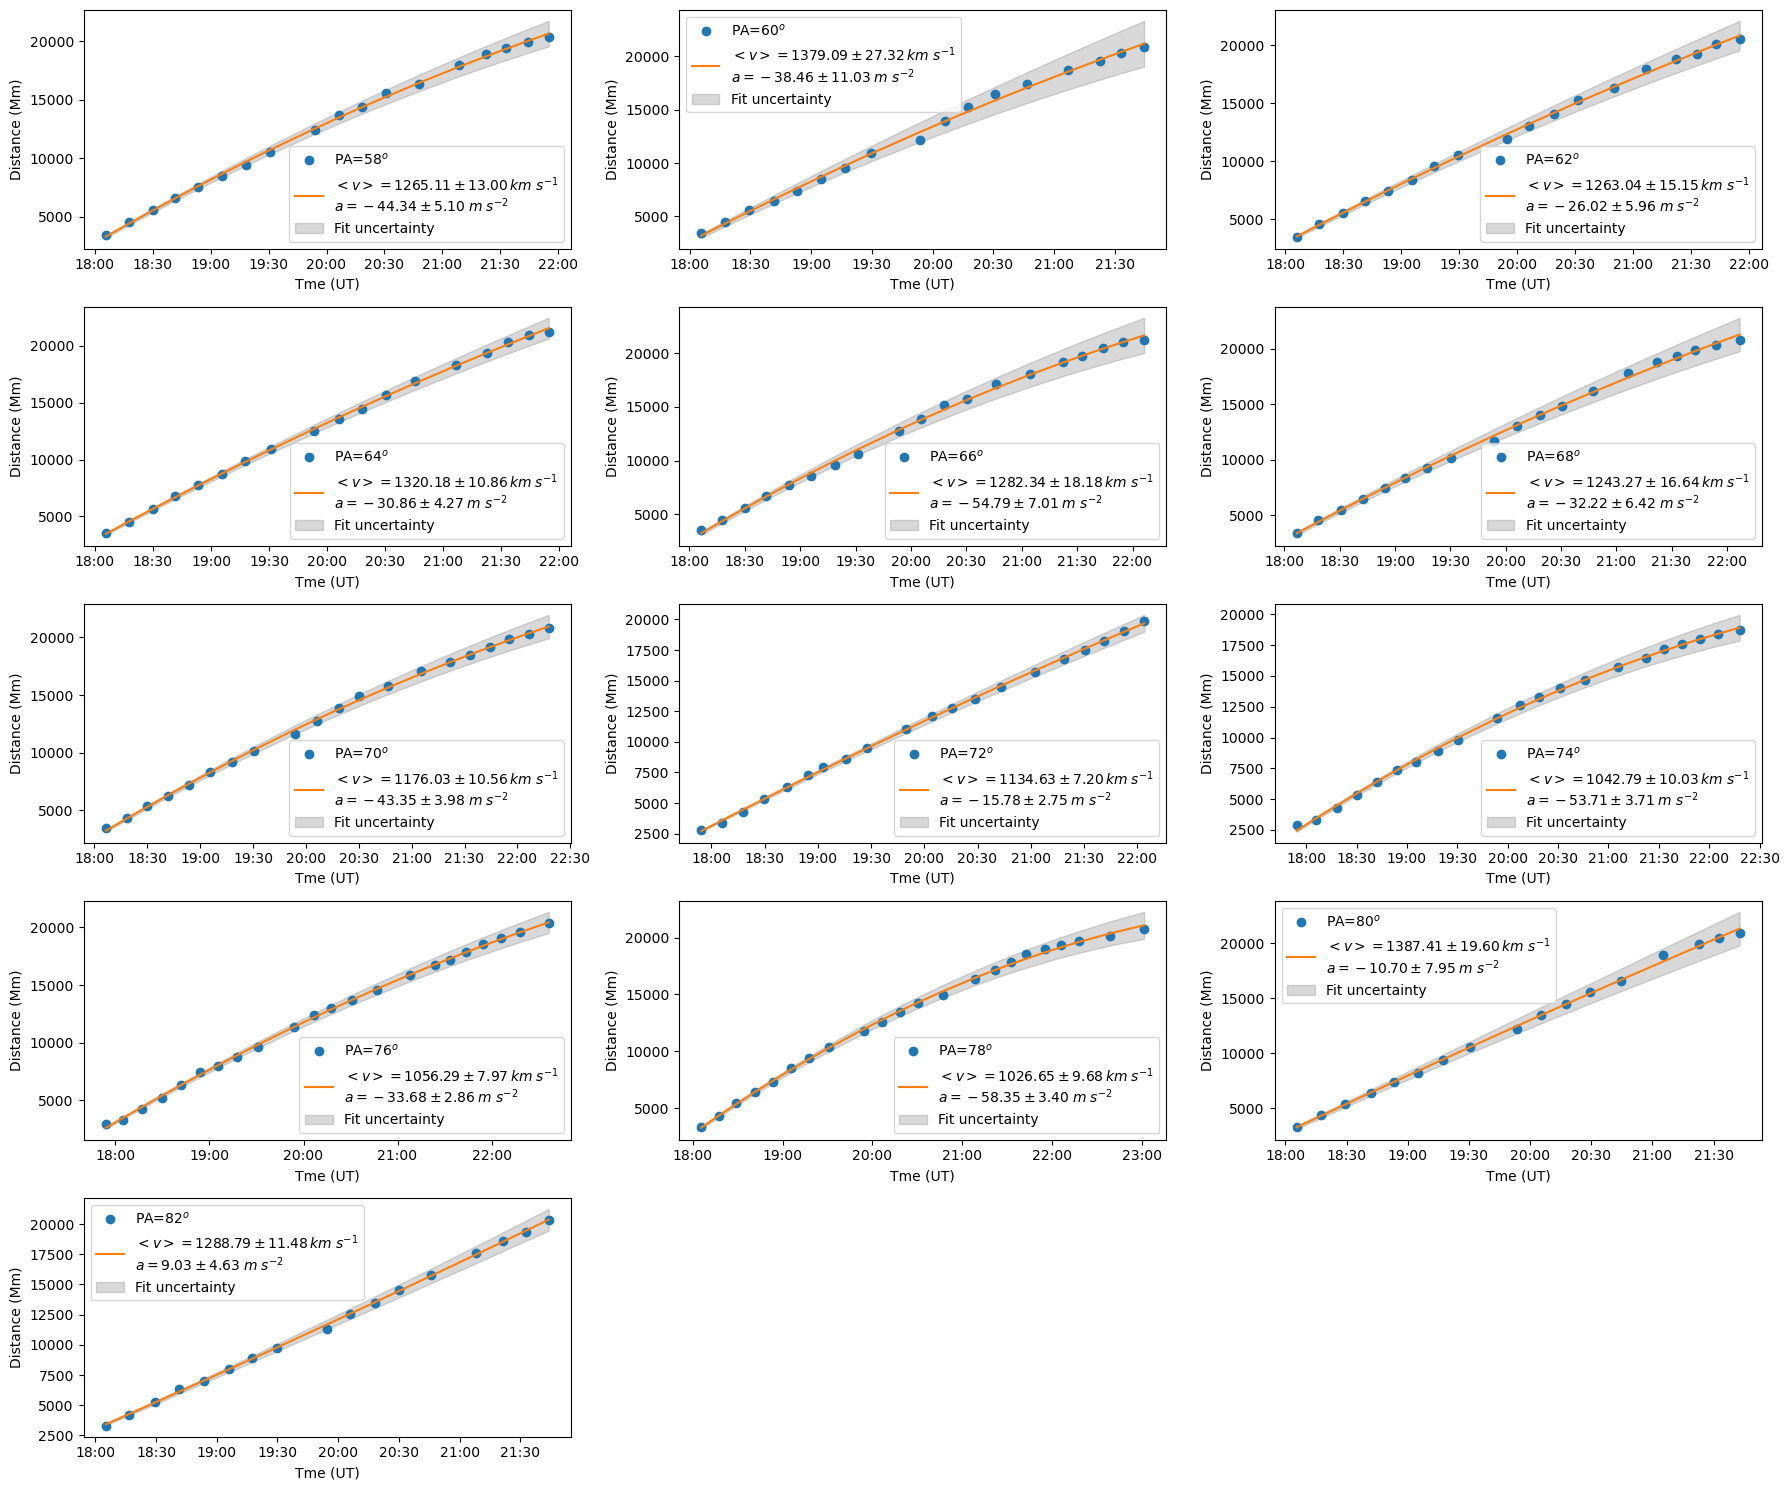

In [62]:
# suvi_filenames, c2_filenames, c3_filenames
instrument_files = c3_filenames

# Initialize empty lists to store results
fit_results_c3 = []
all_times_c3 = []
all_speeds_km_s_c3 = []
all_accels_m_s2_c3 = []
all_fit_dist_Mm_c3 = []

num_files = len(instrument_files)
cols = 3  # Number of columns in the figure
rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
bins = 10
fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))  # Make a grid of subplots
axes = axes.flatten()  # Flatten in case of a 2D array of axes

for i, file in enumerate(instrument_files):
    df = pd.read_csv(file)
    
    angle = file.split('_')[-1][:-4]
    # rename the angles to be position angles, instead of geometric angles
    PA_value = int(angle) - 90
    
    # calc speed via savgol filter, in km/s
    x = df['time']
    y = df['distance_km']
    y_Mm = [(y_km*u.km).to('Mm').value for y_km in y]
    
    # apply the kinematic fit
    # ========================
    time_array = np.array([mdates.num2date(xtime) for xtime in x], dtype='datetime64[ms]')  # Use milliseconds for precision
    # Convert datetime array to seconds starting from zero
    time = (time_array - time_array[0]) / np.timedelta64(1, 's')  # Convert to seconds
    
    # Apply the fit to each segment
    fitted, velocity, velocity_err, acceleration, s0, v0, a, init_pos_err, init_vel_err, a_err = fit_kinematics(time, y_Mm, d1=4, d2=30)
    
    # Calculate upper and lower bounds using parameter errors
    fitted_distance_upper = kinematic_model(time, s0+init_pos_err, v0+init_vel_err, a+a_err)
    fitted_distance_lower = kinematic_model(time, s0-init_pos_err, v0-init_vel_err, a-a_err)
    
    # Convert units to desired formats
    velocity     *= 1_000         # Convert velocity from Mm/s to km/s
    velocity_err *= 1_000         # Convert velocity from Mm/s to km/s
    v0           *= 1_000         # Convert velocity from Mm/s to km/s
    init_vel_err *= 1_000         # Convert velocity error from Mm/s to km/s
    a     *= 1_000                # Convert acceleration from Mm/s² to km/s²
    a_err *= 1_000                # Convert acceleration error from Mm/s² to km/s²
    
    # Estimate velocities
    t_start = time[0]
    t_end   = time[-1]
    
    # Minimum velocity (at t_start)
    v_min     = v0 + a*t_start
    v_min_err = np.sqrt(init_vel_err**2 + (t_start*a_err)**2)
    
    # Maximum velocity (at t_end)
    v_max     = v0 + a*t_end
    v_max_err = np.sqrt(init_vel_err**2 + (t_end*a_err)**2)
    
    # Mean velocity (average of v_min and v_max)
    # v_mean = (v_min + v_max) / 2
    # v_mean_err = 0.5 * np.sqrt(v_min_err**2 + v_max_err**2)
    v_mean     = np.nanmean(velocity)
    v_mean_err = np.sqrt(np.nansum(velocity_err**2)) / len(velocity)
    
    # Convert units to desired formats
    a     *= 1_000                # Convert acceleration from km/s² to m/s²
    a_err *= 1_000                # Convert acceleration error from km/s² to m/s²
    acceleration *= 1_000_000     # Convert acceleration from Mm/s² to m/s²

    # store all speed and accels. --> Why am I doing this? --> To get the overall distribution of each variable
    all_times_c3.append(time_array)
    all_speeds_km_s_c3.append(velocity)
    all_accels_m_s2_c3.append(acceleration) # `a` is same as `acceleration` but one value per slit.
    all_fit_dist_Mm_c3.append(fitted)
    
    # Store results as a dictionary
    fit_results_c3.append({
        'PA': PA_value,
        's0_Mm': s0,
        'v0_km/s': v0,
        'a_m/s2': a,
        'v_min_km/s': v_min,
        'v_max_km/s': v_max,
        'v_mean_km/s': v_mean,
        'init_pos_err_Mm': init_pos_err,
        'init_vel_err_km/s': init_vel_err,
        'a_err_m/s2': a_err,
        'v_min_err_km/s': v_min_err,
        'v_max_err_km/s': v_max_err,
        'v_mean_err_km/s': v_mean_err
    })
    
    ax = axes[i]  # Use the i-th subplot
    ax.plot(x, y_Mm, 'o', label=rf'PA={PA_value}$^o$')
    ax.plot(x, fitted, '-', label=rf'$<v>={v_mean:.2f} \pm {v_mean_err:.2f} \, km \; s^{{-1}}$' '\n' 
                            rf'$a={a:.2f} \pm {a_err:.2f} \; m \; s^{{-2}}$')
    # Plot error bounds as shaded area
    ax.fill_between(x, fitted_distance_lower, fitted_distance_upper, color='gray', alpha=0.3, label='Fit uncertainty')
    ax.set_ylabel('Distance (Mm)')
    ax.set_xlabel('Tme (UT)')
    ax.legend(loc='best')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Output the fitted parameters for one segment
    # print(f'Slit {PA_value}: Initial Position (s0) = {s0:.2f} Mm, Initial Velocity (v0) = {v0:.2f} km/s, Acceleration (a) = {a:.2f} m/s^2')
    # print(f'Distance mean uncertainity: {np.nanmean(fitted_distance_upper-fitted_distance_lower):.2f} Mm\n')

# Hide unused subplots if `num_files` is not a multiple of `cols`
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Convert list to DataFrame
fit_df_c3 = pd.DataFrame(fit_results_c3)
fit_df_c3 = fit_df_c3.applymap(lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else x)
# Ensure fit_df stays numeric
fit_df_c3 = fit_df_c3.astype(float)  # Convert all numeric columns back to floats

fig.tight_layout()
plt.show()

In [63]:
fit_df_c3

,PA,s0_Mm,v0_km/s,a_m/s2,v_min_km/s,v_max_km/s,v_mean_km/s,init_pos_err_Mm,init_vel_err_km/s,a_err_m/s2,v_min_err_km/s,v_max_err_km/s,v_mean_err_km/s
0,58.0,3304.78,1566.85,-44.34,1566.85,956.48,1265.11,105.14,36.58,5.10,36.58,79.18,13.00
1,60.0,3182.97,1624.06,-38.46,1624.06,1118.90,1379.09,205.62,75.17,11.03,75.17,163.22,27.32
2,62.0,3499.77,1439.62,-26.02,1439.62,1081.53,1263.04,121.58,42.58,5.96,42.58,92.44,15.15
3,64.0,3463.87,1529.50,-30.86,1529.50,1105.93,1320.18,88.07,30.60,4.27,30.60,66.13,10.86
4,66.0,3232.29,1673.62,-54.79,1673.62,885.02,1282.34,157.68,52.44,7.01,52.44,113.78,18.18
5,68.0,3372.93,1473.38,-32.22,1473.38,1008.84,1243.27,143.55,47.95,6.42,47.95,104.27,16.64
6,70.0,3212.57,1502.96,-43.35,1502.96,849.58,1176.03,97.77,31.12,3.98,31.12,67.56,10.56
7,72.0,2713.45,1250.90,-15.78,1250.90,1014.57,1134.63,66.97,21.42,2.75,21.42,46.41,7.20
8,74.0,2443.80,1465.74,-53.71,1465.74,615.73,1042.79,100.04,30.37,3.71,30.37,66.05,10.03
9,76.0,2623.10,1336.30,-33.68,1336.30,765.38,1056.29,86.04,24.67,2.86,24.67,54.35,7.97


In [66]:
summary_c3 = fit_df_c3[['s0_Mm', 'v0_km/s', 'a_m/s2']].agg(['min', 'max', 'mean', 'median', 'std']).round(2)
summary_c3

,s0_Mm,v0_km/s,a_m/s2
min,2443.80,1231.06,-58.35
max,3499.77,1673.62,9.03
mean,3154.95,1466.89,-33.33
median,3265.71,1473.38,-33.68
std,338.71,130.94,19.20


In [67]:
# errors
fit_df_c3[['init_pos_err_Mm', 'init_vel_err_km/s','a_err_m/s2']].agg(['min', 'max', 'mean', 'median', 'std']).round(2)

,init_pos_err_Mm,init_vel_err_km/s,a_err_m/s2
min,66.97,21.42,2.75
max,205.62,75.17,11.03
mean,116.63,39.12,5.31
median,105.14,31.56,4.63
std,37.90,14.91,2.35


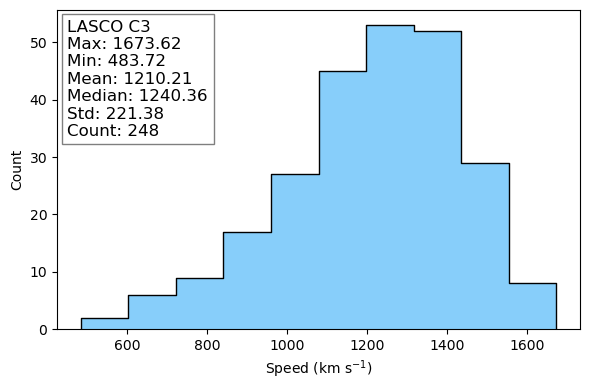

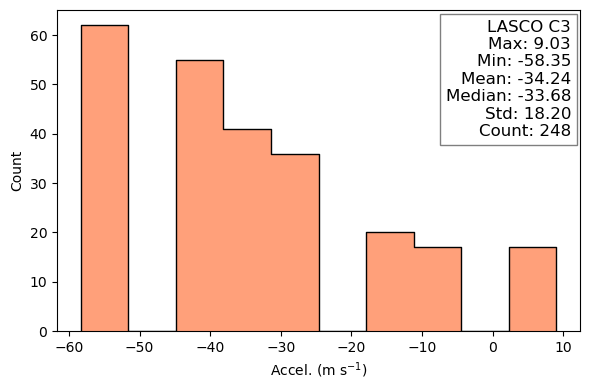

In [68]:
combined_array_v = np.concatenate(all_speeds_km_s_c3)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

# Plot a histogram of the combined data
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(combined_array_v, bins=10, color='lightskyblue', label='LASCO C3')
# Construct the outline around the histogram
outline_x = np.repeat(bins, 2)[1:-1]  # Duplicate bin edges for step-like connection
outline_y = np.repeat(n, 2)  # Duplicate counts for step-like outline
# Add starting and ending points to close the outline
outline_x = np.concatenate(([bins[0]], outline_x, [bins[-1]]))
outline_y = np.concatenate(([0], outline_y, [0]))
# Plot the outline
ax.plot(outline_x, outline_y, color='black', linewidth=1)
ax.set_xlabel(r'Speed (km s$^{-1}$)')
ax.set_ylabel('Count')
# Add statistics to the top-right corner of the plot
stats_text_v = f'LASCO C3\nMax: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
ax.text(0.02, 0.97, stats_text_v, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))
fig.tight_layout()
# fig.savefig(f'{data_dir}/euv_stats_speed_c3.pdf', format='pdf', bbox_inches='tight')
plt.show()

# ============================================================

combined_array_a = np.concatenate(all_accels_m_s2_c3)

# Calculate basic statistics
max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(combined_array_a, bins=10, color='lightsalmon', label='LASCO C3')
# Construct the outline around the histogram
outline_x = np.repeat(bins, 2)[1:-1]  # Duplicate bin edges for step-like connection
outline_y = np.repeat(n, 2)  # Duplicate counts for step-like outline
# Add starting and ending points to close the outline
outline_x = np.concatenate(([bins[0]], outline_x, [bins[-1]]))
outline_y = np.concatenate(([0], outline_y, [0]))
# Plot the outline
ax.plot(outline_x, outline_y, color='black', linewidth=1)
ax.set_xlabel(r'Accel. (m s$^{-1}$)')
ax.set_ylabel('Count')
# Add statistics to the top-right corner of the plot
stats_text_a = f'LASCO C3\nMax: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
ax.text(0.983, 0.97, stats_text_a, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
fig.tight_layout()
# fig.savefig(f'{data_dir}/euv_stats_accel_c3.pdf', format='pdf', bbox_inches='tight')
plt.show()

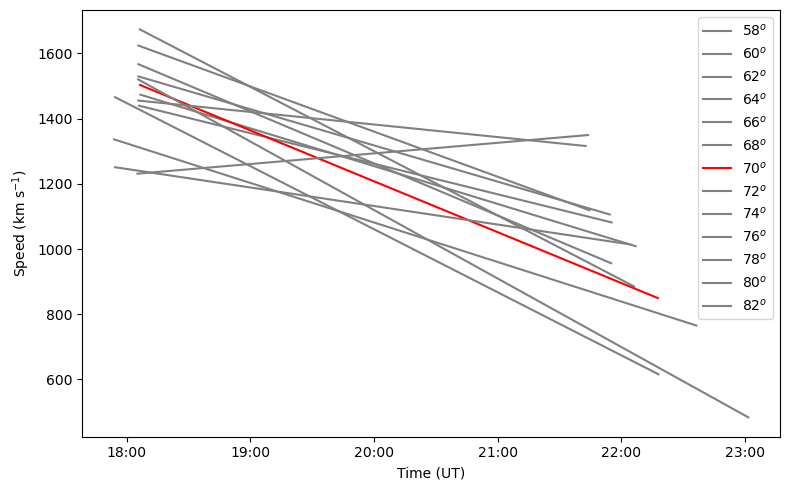

In [43]:
fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

for pa, t, v in zip(fit_df['PA'], all_times_c3, all_speeds_km_s_c3):
    ax.plot(t, v, label=rf'{round(pa)}$^o$')
    # if pa==70:
    #     line_color = 'red'
    # else:
    #     line_color = 'gray'
    # ax.plot(t, v, color=line_color)

ax.set_ylabel(r'Speed (km s$^{-1}$)')
ax.set_xlabel('Time (UT)')
ax.legend()
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

## Speeds

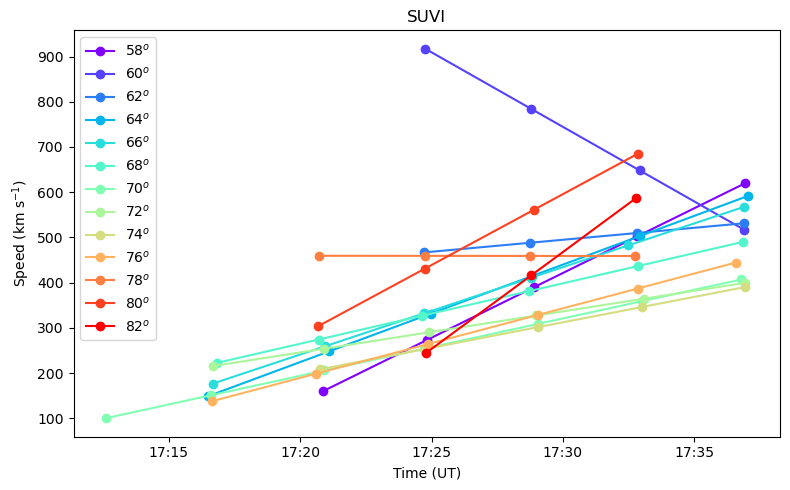

In [102]:
fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

# Normalize PA values to colormap range
norm = mcolors.Normalize(vmin=min(fit_df['PA']), vmax=max(fit_df['PA']))
cmap = cm.get_cmap('rainbow')  # 'rainbow', 'viridis', 'plasma', etc.

for pa, t, v in zip(fit_df['PA'], all_times_suvi, all_speeds_km_s_suvi):
    ax.plot(t, v, '-o', label=rf'{round(pa)}$^o$', color=cmap(norm(pa)))

ax.set_ylabel(r'Speed (km s$^{-1}$)')
ax.set_xlabel('Time (UT)')
ax.set_title('SUVI')
ax.legend()
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

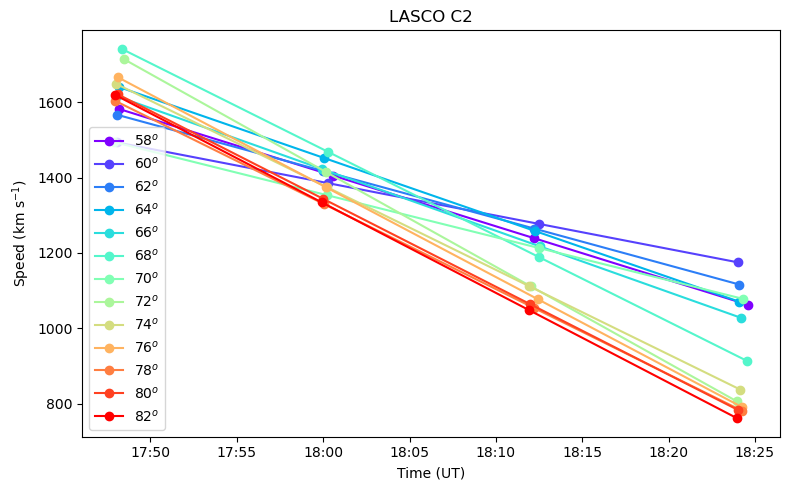

In [104]:
fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

# Normalize PA values to colormap range
norm = mcolors.Normalize(vmin=min(fit_df['PA']), vmax=max(fit_df['PA']))
cmap = cm.get_cmap('rainbow')  # 'rainbow', 'viridis', 'plasma', etc.

for pa, t, v in zip(fit_df['PA'], all_times_c2, all_speeds_km_s_c2):
    ax.plot(t, v, '-o', label=rf'{round(pa)}$^o$', color=cmap(norm(pa)))

ax.set_ylabel(r'Speed (km s$^{-1}$)')
ax.set_xlabel('Time (UT)')
ax.set_title('LASCO C2')
ax.legend()
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

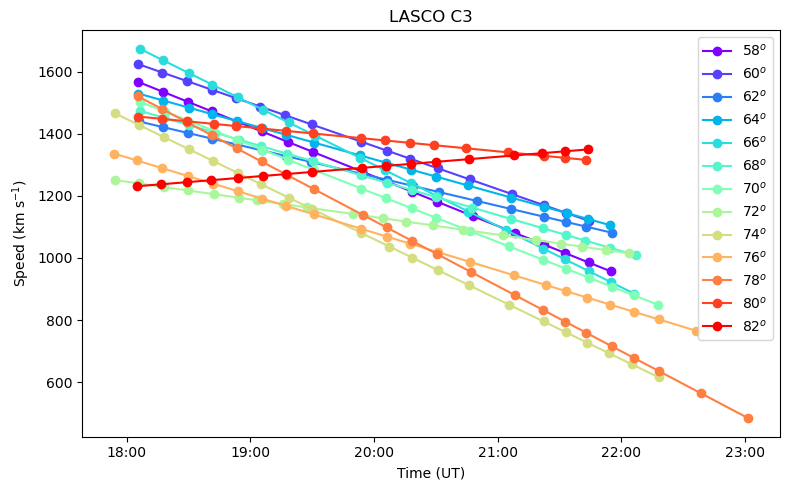

In [105]:
fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

# Normalize PA values to colormap range
norm = mcolors.Normalize(vmin=min(fit_df['PA']), vmax=max(fit_df['PA']))
cmap = cm.get_cmap('rainbow')  # 'rainbow', 'viridis', 'plasma', etc.

for pa, t, v in zip(fit_df['PA'], all_times_c3, all_speeds_km_s_c3):
    ax.plot(t, v, '-o', label=rf'{round(pa)}$^o$', color=cmap(norm(pa)))

ax.set_ylabel(r'Speed (km s$^{-1}$)')
ax.set_xlabel('Time (UT)')
ax.set_title('LASCO C3')
ax.legend()
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

## Accelerations

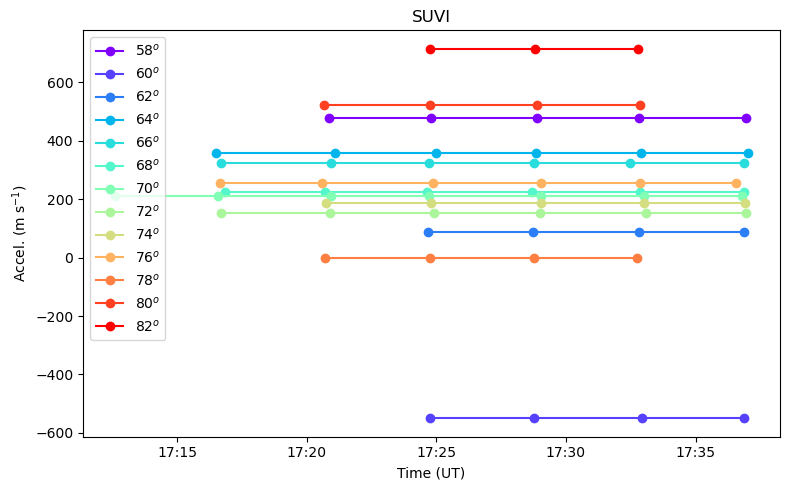

In [106]:
fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

# Normalize PA values to colormap range
norm = mcolors.Normalize(vmin=min(fit_df['PA']), vmax=max(fit_df['PA']))
cmap = cm.get_cmap('rainbow')  # 'rainbow', 'viridis', 'plasma', etc.

for pa, t, v in zip(fit_df['PA'], all_times_suvi, all_accels_m_s2_suvi):
    ax.plot(t, v, '-o', label=rf'{round(pa)}$^o$', color=cmap(norm(pa)))

ax.set_ylabel(r'Accel. (m s$^{-1}$)')
ax.set_xlabel('Time (UT)')
ax.set_title('SUVI')
ax.legend()
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

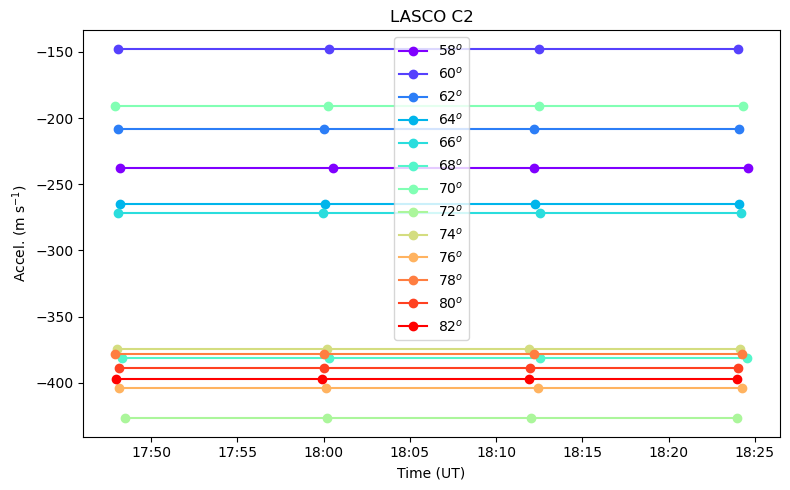

In [107]:
fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

# Normalize PA values to colormap range
norm = mcolors.Normalize(vmin=min(fit_df['PA']), vmax=max(fit_df['PA']))
cmap = cm.get_cmap('rainbow')  # 'rainbow', 'viridis', 'plasma', etc.

for pa, t, v in zip(fit_df['PA'], all_times_c2, all_accels_m_s2_c2):
    ax.plot(t, v, '-o', label=rf'{round(pa)}$^o$', color=cmap(norm(pa)))

ax.set_ylabel(r'Accel. (m s$^{-1}$)')
ax.set_xlabel('Time (UT)')
ax.set_title('LASCO C2')
ax.legend()
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

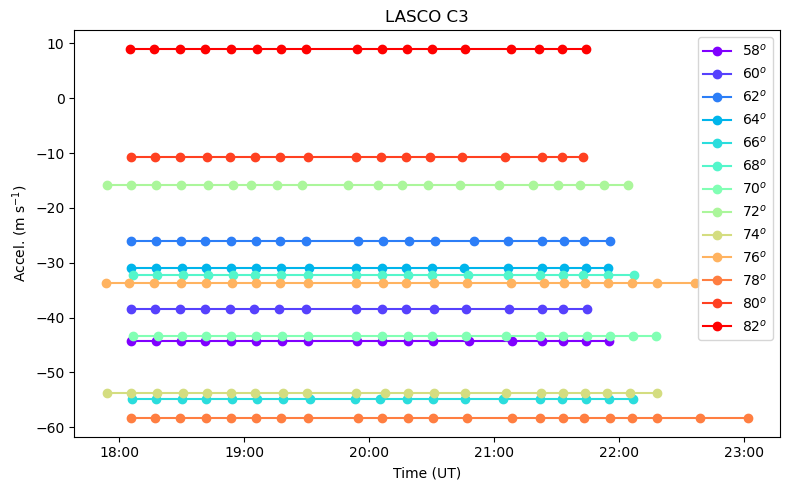

In [108]:
fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

# Normalize PA values to colormap range
norm = mcolors.Normalize(vmin=min(fit_df['PA']), vmax=max(fit_df['PA']))
cmap = cm.get_cmap('rainbow')  # 'rainbow', 'viridis', 'plasma', etc.

for pa, t, v in zip(fit_df['PA'], all_times_c3, all_accels_m_s2_c3):
    ax.plot(t, v, '-o', label=rf'{round(pa)}$^o$', color=cmap(norm(pa)))

ax.set_ylabel(r'Accel. (m s$^{-1}$)')
ax.set_xlabel('Time (UT)')
ax.set_title('LASCO C3')
ax.legend()
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [128]:
# instrument_files = suvi_filenames

# num_files = len(instrument_files)
# cols = 3  # Number of columns in the figure
# rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
# bins = 10
# fig, axes = plt.subplots(rows, cols, figsize=(15, 2 * rows))  # Make a grid of subplots
# axes = axes.flatten()  # Flatten in case of a 2D array of axes

# for i, file in enumerate(instrument_files):
#     df = pd.read_csv(file)
    
#     angle = file.split('_')[-1][:-4]
#     # rename the angles to be position angles, instead of geometric angles
#     PA_value = int(angle) - 90
    
#     # calc speed via savgol filter, in km/s
#     x = df['time']
#     y = df['distance_km']
#     # fix the time (in seconds) and distance (in km)
#     xtimes = np.array([mdates.num2date(date) for date in x])
#     mean_dt = np.mean([x.total_seconds() for x in np.diff(xtimes)]) # because the time spacing is not equal
#     # if len(y) < 5:
#     #     window_size = 3
#     # else:
#     #     window_size = 5
#     window_size = 3
#     speed = savgol_filter(y, window_length=window_size, polyorder=2, deriv=1, delta=mean_dt)
#     # calc accel via savgol filter, in m/s2
#     accel = savgol_filter(speed*1e3, window_length=window_size, polyorder=2, deriv=1, delta=mean_dt)
    
#     ax = axes[i]  # Use the i-th subplot
#     ax.plot(x, speed, '-o', label=rf'PA={PA_value}$^o$')
#     ax.set_ylabel(r'Speed (km s$^{-1}$)')
#     ax.set_xlabel('Tme (UT)')
#     ax.legend(loc='best')
#     ax.xaxis_date()
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Hide unused subplots if `num_files` is not a multiple of `cols`
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# fig.tight_layout()
# plt.show()

In [ ]:
all_speeds_c2 = []
all_accels_c2 = []
all_times_c2  = []
all_dists_c2  = []
for file in c2_filenames:
    df = pd.read_csv(file)
    df['speed_diff'] = df['speed_km_s'].diff()
    # calculate the Accel. in m/s2
    df['accel_m_s2'] = (df['speed_diff']*1e3) / df['time_diff_s']
    # store all speed and accels.
    all_speeds_c2.append(df['speed_km_s'].values)
    all_accels_c2.append(df['accel_m_s2'].values)
    all_times_c2.append(df['time'].values)
    all_dists_c2.append(df['distance_km'].values/sun_radius_km)

# Combine the 1D arrays into a single 1D array
combined_array_v = np.concatenate(all_speeds_c2)
combined_array_a = np.concatenate(all_accels_c2)
combined_array_t = np.concatenate(all_times_c2)
combined_array_d = np.concatenate(all_dists_c2)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

max_d = np.nanmax(combined_array_d)
min_d = np.nanmin(combined_array_d)
print(f"Start height: {min_d:.2f} Rs")
print(f"End height:  {max_d:.2f} Rs")

max_t = datetime.strftime(mdates.num2date(np.nanmax(combined_array_t)), '%Y-%m-%d %H:%M:%S')
min_t = datetime.strftime(mdates.num2date(np.nanmin(combined_array_t)), '%Y-%m-%d %H:%M:%S')
print(f"\nStart time: {min_t}")
print(f"End time:  {max_t}")

# Plot a histogram of the combined data
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
ax.hist(combined_array_v, bins=10, color='tab:blue', label='LASCO C2',
         # edgecolor='black'
        )
ax.set_xlabel(r'Speed (km s$^{-1}$)')
ax.set_ylabel('Count')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_v = f'Max: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
ax.text(0.985, 0.97, stats_text_v, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
fig.tight_layout()
fig.savefig(f'{data_dir}/euv_stats_speed_c2.pdf', format='pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
ax.hist(combined_array_a, bins=10, color='tab:orange', label='LASCO C2')
ax.set_xlabel(r'Accel. (m s$^{-1}$)')
ax.set_ylabel('Count')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_a = f'Max: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
ax.text(0.985, 0.97, stats_text_a, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
fig.tight_layout()
fig.savefig(f'{data_dir}/euv_stats_accel_c2.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
all_speeds_c3 = []
all_accels_c3 = []
all_times_c3  = []
all_dists_c3  = []
for file in c3_filenames:
    df = pd.read_csv(file)
    df['speed_diff'] = df['speed_km_s'].diff()
    # calculate the Accel. in m/s2
    df['accel_m_s2'] = (df['speed_diff']*1e3) / df['time_diff_s']
    # store all speed and accels.
    all_speeds_c3.append(df['speed_km_s'].values)
    all_accels_c3.append(df['accel_m_s2'].values)
    all_times_c3.append(df['time'].values)
    all_dists_c3.append(df['distance_km'].values/sun_radius_km)

# Combine the 1D arrays into a single 1D array
combined_array_v = np.concatenate(all_speeds_c3)
combined_array_a = np.concatenate(all_accels_c3)
combined_array_t = np.concatenate(all_times_c3)
combined_array_d = np.concatenate(all_dists_c3)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

max_d = np.nanmax(combined_array_d)
min_d = np.nanmin(combined_array_d)
print(f"Start height: {min_d:.2f} Rs")
print(f"End height:  {max_d:.2f} Rs")

max_t = datetime.strftime(mdates.num2date(np.nanmax(combined_array_t)), '%Y-%m-%d %H:%M:%S')
min_t = datetime.strftime(mdates.num2date(np.nanmin(combined_array_t)), '%Y-%m-%d %H:%M:%S')
print(f"\nStart time: {min_t}")
print(f"End time:  {max_t}")

# Plot a histogram of the combined data
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
ax.hist(combined_array_v, bins=10, color='tab:blue', label='LASCO C3')
ax.set_xlabel(r'Speed (km s$^{-1}$)')
ax.set_ylabel('Count')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_v = f'Max: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
ax.text(0.985, 0.97, stats_text_v, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
fig.tight_layout()
# fig.savefig(f'{data_dir}/euv_stats_speed_c3.pdf', format='pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
ax.hist(combined_array_a, bins=10, color='tab:orange', label='LASCO C3')
ax.set_xlabel(r'Accel. (m s$^{-1}$)')
ax.set_ylabel('Count')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_a = f'Max: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
ax.text(0.985, 0.97, stats_text_a, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
fig.tight_layout()
# fig.savefig(f'{data_dir}/euv_stats_accel_c3.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# SUVI, LASCO C2, LASCO C3
# suvi_filenames, c2_filenames, c3_filenames
instrument_name = 'LASCO C3'
instrument_files = c3_filenames

Inspect individual instrument files

In [ ]:
# df = pd.read_csv(instrument_files[0])
# df['speed_diff'] = df['speed_km_s'].diff()
# df['accel_m_s2'] = (df['speed_diff']*1e3) / df['time_diff_s'] # calculate the Accel. in m/s2
# print(instrument_files[0])
# display(df.head())

# angle = instrument_files[0].split('_')[-1][:-4]
# speed = df['speed_km_s']
# accel = df['accel_m_s2']

# # Calculate basic statistics
# max_v    = np.nanmax(speed)
# min_v    = np.nanmin(speed)
# mean_v   = np.nanmean(speed)
# median_v = np.nanmedian(speed)
# std_v    = np.nanstd(speed)
# count_v  = speed.size

# max_a    = np.nanmax(accel)
# min_a    = np.nanmin(accel)
# mean_a   = np.nanmean(accel)
# median_a = np.nanmedian(accel)
# std_a    = np.nanstd(accel)
# count_a  = accel.size

# bins = 10
# fig = plt.figure(figsize=[12,4])

# ax = fig.add_subplot(121)
# ax.hist(speed, bins=bins, color='dodgerblue', label=rf'SUVI: {angle}$^o$')
# ax.set_xlabel(r'Speed (km s$^{-1}$)')
# ax.set_ylabel('Count')
# ax.legend(loc='upper left', frameon=False)
# stats_text_v = f'Max: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
# ax.text(0.985, 0.97, stats_text_v, transform=ax.transAxes, fontsize=12,
#          verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

# ax = fig.add_subplot(122)
# ax.hist(accel, bins=bins, color='crimson', label=rf'{instrument_name}: {angle}$^o$')
# ax.set_xlabel(r'Accel. (m s$^{-1}$)')
# ax.legend(loc='upper left', frameon=False)
# stats_text_a = f'Max: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
# ax.text(0.985, 0.97, stats_text_a, transform=ax.transAxes, fontsize=12,
#          verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
# fig.tight_layout()
# plt.show()

Plot all slits in the instrument FOV

In [ ]:
instrument_files

In [ ]:
file = instrument_files[0]
df = pd.read_csv(file)
df.head()

In [ ]:
fig, ax = plt.subplots(figsize=[10,5])
ax.plot(df['time'], df['distance_km']/1e6, '-o')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

In [ ]:
x = np.array([2, 2, 5, 2, 1, 0, 1, 4, 9])
savgol_filter(x, 5, 2)
# savgol_filter(x, 5, 2, mode='nearest')

In [ ]:
x = df['time']
y = df['distance_km']

y

In [ ]:
y[0]

In [ ]:
y[0]/const.radius.to('km').value

In [ ]:
ig, ax = plt.subplots(figsize=[8,4])
ax.plot(x, y/const.radius.to('km').value, '-o')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Radial Distance (Rsun)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

In [ ]:
np.array(x), np.array(y)

In [ ]:
# fix the time (in seconds) and distance (in km). This should fix the fittings ...
xtimes = np.array([mdates.num2date(date) for date in x])
dt = xtimes[1] - xtimes[0]
dt

In [ ]:
xtimes

In [ ]:
[x.total_seconds() for x in np.diff(xtimes)]

In [ ]:
plt.figure()
plt.plot([x.total_seconds()/60 for x in np.diff(xtimes)], '-o')
plt.xlabel('Step')
plt.ylabel('dt in minutes')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
dt.total_seconds()

In [ ]:
# speed = savgol_filter(y/const.radius.to('km').value, window_length=3, polyorder=2, deriv=1, delta = x[1]-x[0])
speed = savgol_filter(y, window_length=5, polyorder=2, deriv=1, delta=(xtimes[1]-xtimes[0]).total_seconds())

fig, ax = plt.subplots(figsize=[8,4])
ax.plot(x, speed, '-o', color='crimson', label='window_length=3')
ax.legend(loc='lower left')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Speed (km/s)')
ax.set_title('window size=5, using time difference (t[1]-t[0])')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

In [ ]:
mean_dt = np.mean([x.total_seconds() for x in np.diff(xtimes)])
speed = savgol_filter(y, window_length=5, polyorder=2, deriv=1, delta=mean_dt)

fig, ax = plt.subplots(figsize=[8,4])
ax.plot(x, speed, '-o', color='crimson', label='window_length=3')
ax.legend(loc='lower left')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Speed (km/s)')
ax.set_title('window size=5, using mean time difference (13.49 seconds)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

In [ ]:
num_files = len(instrument_files)
cols = 3  # Number of columns in the figure
rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
bins = 10
fig, axes = plt.subplots(rows, cols, figsize=(12, 2 * rows))  # Make a grid of subplots
axes = axes.flatten()  # Flatten in case of a 2D array of axes

for i, file in enumerate(instrument_files):
    df = pd.read_csv(file)
    angle = file.split('_')[-1][:-4]
    speed = df['speed_km_s']
    
    # Calculate statistics
    max_v = np.nanmax(speed)
    min_v = np.nanmin(speed)
    mean_v = np.nanmean(speed)
    median_v = np.nanmedian(speed)
    std_v = np.nanstd(speed)
    count_v = speed.size
    
    ax = axes[i]  # Use the i-th subplot
    ax.hist(speed, bins=bins, color='dodgerblue')
    ax.set_xlabel(r'Speed (km s$^{-1}$)')
    ax.set_ylabel('Count')
    ax.legend(loc='upper left', frameon=False)
    
    stats_text_v = f'{instrument_name} slit: {angle}$^o$\nMax: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
    ax.text(0.985, 0.97, stats_text_v, transform=ax.transAxes, fontsize=9,
             verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

# Hide unused subplots if `num_files` is not a multiple of `cols`
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [ ]:
num_files = len(instrument_files)
cols = 3  # Number of columns in the figure
rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
bins = 10
fig, axes = plt.subplots(rows, cols, figsize=(12, 2 * rows))  # Make a grid of subplots
axes = axes.flatten()  # Flatten in case of a 2D array of axes

for i, file in enumerate(instrument_files):
    df = pd.read_csv(file)
    df['speed_diff'] = df['speed_km_s'].diff()
    df['accel_m_s2'] = (df['speed_diff'] * 1e3) / df['time_diff_s']  # Acceleration in m/s²

    angle = file.split('_')[-1][:-4]
    accel = df['accel_m_s2']
    
    # Calculate statistics
    max_a    = np.nanmax(accel)
    min_a    = np.nanmin(accel)
    mean_a   = np.nanmean(accel)
    median_a = np.nanmedian(accel)
    std_a    = np.nanstd(accel)
    count_a  = accel.size
    
    ax = axes[i]  # Use the i-th subplot
    ax.hist(accel, bins=bins, color='crimson')
    ax.set_xlabel(r'Accel. (m s$^{-2}$)')
    ax.set_ylabel('Count')
    ax.legend(loc='upper left', frameon=False)
    
    stats_text_a = f'{instrument_name} slit: {angle}$^o$\nMax: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
    ax.text(0.985, 0.97, stats_text_a, transform=ax.transAxes, fontsize=9,
             verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

# Hide unused subplots if `num_files` is not a multiple of `cols`
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

Plot speeds and accel time series

In [ ]:
num_files = len(instrument_files)
cols = 3  # Number of columns in the figure
rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
bins = 10
fig, axes = plt.subplots(rows, cols, figsize=(15, 2 * rows))  # Make a grid of subplots
axes = axes.flatten()  # Flatten in case of a 2D array of axes

for i, file in enumerate(instrument_files):
    df = pd.read_csv(file)
    subdf = df[['time','speed_km_s']]
    angle = file.split('_')[-1][:-4]
    
    ax = axes[i]  # Use the i-th subplot
    ax.plot(subdf['time'], subdf['speed_km_s'], '-o', color='dodgerblue', label=f'{instrument_name} slit: {angle}$^o$')
    ax.set_xlabel(f"Time (UT) from {df['datetime'][0].split(' ')[0]}")
    ax.set_ylabel(r'Speed (km s$^{-1}$)')
    ax.legend(loc='lower right')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Hide unused subplots if `num_files` is not a multiple of `cols`
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [ ]:
num_files = len(instrument_files)
cols = 3  # Number of columns in the figure
rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
bins = 10
fig, axes = plt.subplots(rows, cols, figsize=(15, 2 * rows))  # Make a grid of subplots
axes = axes.flatten()  # Flatten in case of a 2D array of axes

for i, file in enumerate(instrument_files):
    df = pd.read_csv(file)
    df['speed_diff'] = df['speed_km_s'].diff()
    df['accel_m_s2'] = (df['speed_diff'] * 1e3) / df['time_diff_s']  # Acceleration in m/s²
    subdf = df[['time','accel_m_s2']]
    angle = file.split('_')[-1][:-4]
    
    ax = axes[i]  # Use the i-th subplot
    ax.plot(subdf['time'], subdf['accel_m_s2'], '-o', color='crimson', label=f'{instrument_name} slit: {angle}$^o$')
    ax.set_xlabel(f"Time (UT) from {df['datetime'][0].split(' ')[0]}")
    ax.set_ylabel(r'Accel. (m s$^{-2}$)')
    ax.legend(loc='lower right')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Hide unused subplots if `num_files` is not a multiple of `cols`
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

Plot speed and accel distrubtion with slits angles

In [ ]:
# Dictionary to hold speeds for each slit angle
speed_data = {}

for file in instrument_files:
    angle = file.split('_')[-1][:-4]  # Extract slit angle
    df = pd.read_csv(file)
    speed_data[angle] = df['speed_km_s'].dropna().values  # Store non-NaN speeds

# Sort by slit angle for correct x-axis ordering
sorted_slit_angles = sorted(speed_data.keys())
numeric_slit_angles = [int(angle) for angle in sorted_slit_angles]

# Prepare data for plotting
speeds_per_slit = [speed_data[angle] for angle in sorted_slit_angles]



fig, ax = plt.subplots(figsize=[10,6])

# Using a violin plot to show speed distribution per slit angle
violin_parts = ax.violinplot(speeds_per_slit, positions=numeric_slit_angles, showmedians=True)

# Plotting the means manually
mean_values = [np.nanmean(speeds) for speeds in speeds_per_slit]
ax.scatter(numeric_slit_angles, mean_values, color='crimson', marker='D', s=40, label='Mean', zorder=10)

median_values = [np.nanmedian(speeds) for speeds in speeds_per_slit]
ax.scatter(numeric_slit_angles, median_values, color='k', marker='o', s=40, label='Median', zorder=10)

std_values = [np.nanstd(speeds) for speeds in speeds_per_slit]
ax.scatter(numeric_slit_angles, std_values, color='tab:green', marker='x', s=40, label='STDV', zorder=10)

# Formatting
ax.set_xlabel('Slit Angle (degrees)')
ax.set_ylabel(r'Speed (km s$^{-1}$)')
ax.set_title(f'Speed Distribution in {instrument_name} FOV Across Slit Angles')
ax.set_xticks(numeric_slit_angles)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [ ]:
# Prepare data for plotting (flatten the speeds for each slit angle)
slit_angles = list(speed_data.keys())
speeds_per_slit = [speed_data[angle] for angle in slit_angles]
mean_speeds = [np.nanmean(speeds) for speeds in speeds_per_slit]

fig, ax = plt.subplots(figsize=[10,6])
ax.bar(slit_angles, mean_speeds, color='tab:blue', alpha=0.7)
ax.set_xlabel('Slit Angle (degrees)')
ax.set_ylabel(r'Mean Speed (km s$^{-1}$)')
ax.set_title(f'Mean Speed Distribution in {instrument_name} FOV Across Slit Angles')
ax.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()

In [ ]:
# Dictionary to hold accel for each slit angle
accel_data = {}

for file in instrument_files:
    angle = file.split('_')[-1][:-4]  # Extract slit angle
    df = pd.read_csv(file)
    df['speed_diff'] = df['speed_km_s'].diff()
    df['accel_m_s2'] = (df['speed_diff'] * 1e3) / df['time_diff_s']  # Acceleration in m/s²
    accel_data[angle] = df['accel_m_s2'].dropna().values  # Store non-NaN speeds

# Sort by slit angle for correct x-axis ordering
sorted_slit_angles = sorted(accel_data.keys())
numeric_slit_angles = [int(angle) for angle in sorted_slit_angles]

# Prepare data for plotting
accel_per_slit = [accel_data[angle] for angle in sorted_slit_angles]



fig, ax = plt.subplots(figsize=[10,6])

# Using a violin plot to show speed distribution per slit angle
violin_parts = ax.violinplot(accel_per_slit, positions=numeric_slit_angles, showmedians=True)

# Plotting the means manually
mean_values = [np.nanmean(accel) for accel in accel_per_slit]
ax.scatter(numeric_slit_angles, mean_values, color='crimson', marker='D', s=40, label='Mean', zorder=10)

median_values = [np.nanmedian(accel) for accel in accel_per_slit]
ax.scatter(numeric_slit_angles, median_values, color='k', marker='o', s=40, label='Median', zorder=10)

std_values = [np.nanstd(accel) for accel in accel_per_slit]
ax.scatter(numeric_slit_angles, std_values, color='tab:green', marker='x', s=40, label='STDV', zorder=10)

# Formatting
ax.set_xlabel('Slit Angle (degrees)')
ax.set_ylabel(r'Accel. (m s$^{-2}$)')
ax.set_title(f'Acceleration Distribution in {instrument_name} FOV Across Slit Angles')
ax.set_xticks(numeric_slit_angles)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [ ]:
# Prepare data for plotting (flatten the accel for each slit angle)
slit_angles = list(accel_data.keys())
accel_per_slit = [accel_data[angle] for angle in slit_angles]
mean_accel = [np.nanmean(accel) for accel in accel_per_slit]

fig, ax = plt.subplots(figsize=[10,6])
ax.bar(slit_angles, mean_accel, color='tab:purple', alpha=0.7)
ax.set_xlabel('Slit Angle (degrees)')
ax.set_ylabel(r'Mean accel. (m s$^{-2}$)')
ax.set_title(f'Mean Acceleration Distribution in {instrument_name} FOV Across Slit Angles')
ax.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()

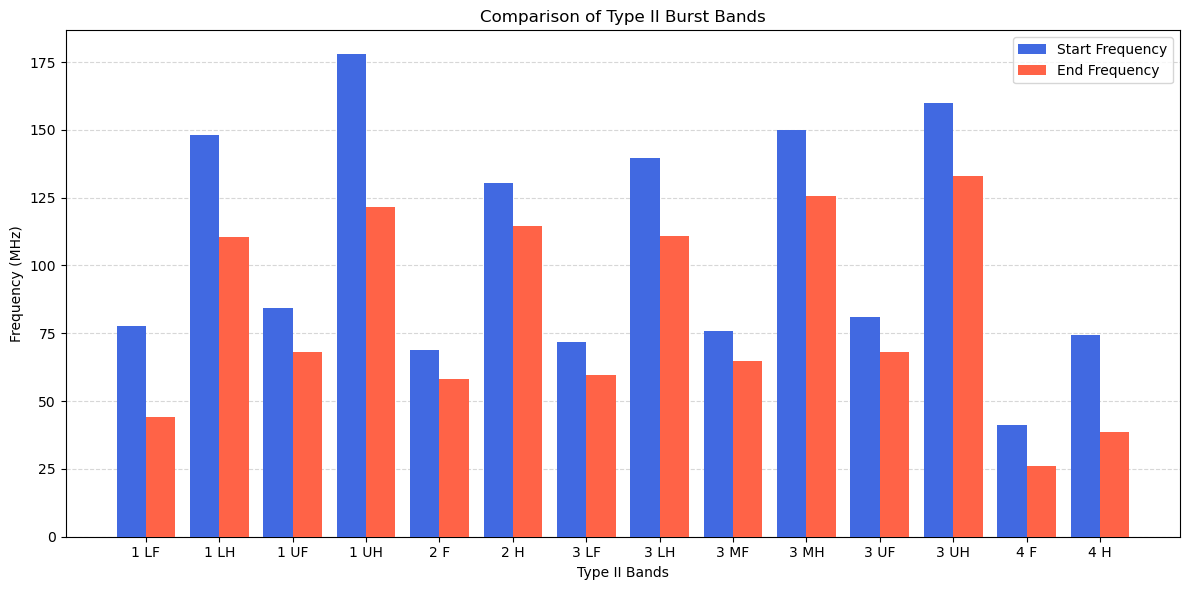

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data from LaTeX table
data = {
    'Band': ['1 LF', '1 LH', '1 UF', '1 UH', '2 F', '2 H', '3 LF', '3 LH', '3 MF', '3 MH', '3 UF', '3 UH', '4 F', '4 H'],
    'Start Frequency (MHz)': [77.61, 148.14, 84.28, 177.81, 68.90, 130.54, 71.80, 139.48, 75.86, 150.05, 80.99, 159.90, 41.07, 74.44],
    'End Frequency (MHz)': [44.07, 110.55, 68.03, 121.39, 57.98, 114.50, 59.58, 111.05, 64.81, 125.63, 68.18, 133.10, 26.10, 38.49]
}

df = pd.DataFrame(data)

# Sorting for better visualization
df['Burst'] = df['Band'].str.extract(r'(\d+)').astype(int)
df['Type'] = df['Band'].str.extract(r'(LF|LH|UF|UH|F|H|MF|MH)')
df = df.sort_values(by=['Burst', 'Type'])

# Setting up bar width
bar_width = 0.4
x = np.arange(len(df))

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, df['Start Frequency (MHz)'], bar_width, label='Start Frequency', color='royalblue', zorder=10)
plt.bar(x + bar_width/2, df['End Frequency (MHz)'], bar_width, label='End Frequency', color='tomato', zorder=10)

plt.xlabel('Type II Bands')
plt.ylabel('Frequency (MHz)')
plt.title('Comparison of Type II Burst Bands')
plt.xticks(x, df['Band'], rotation=0, ha='center')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

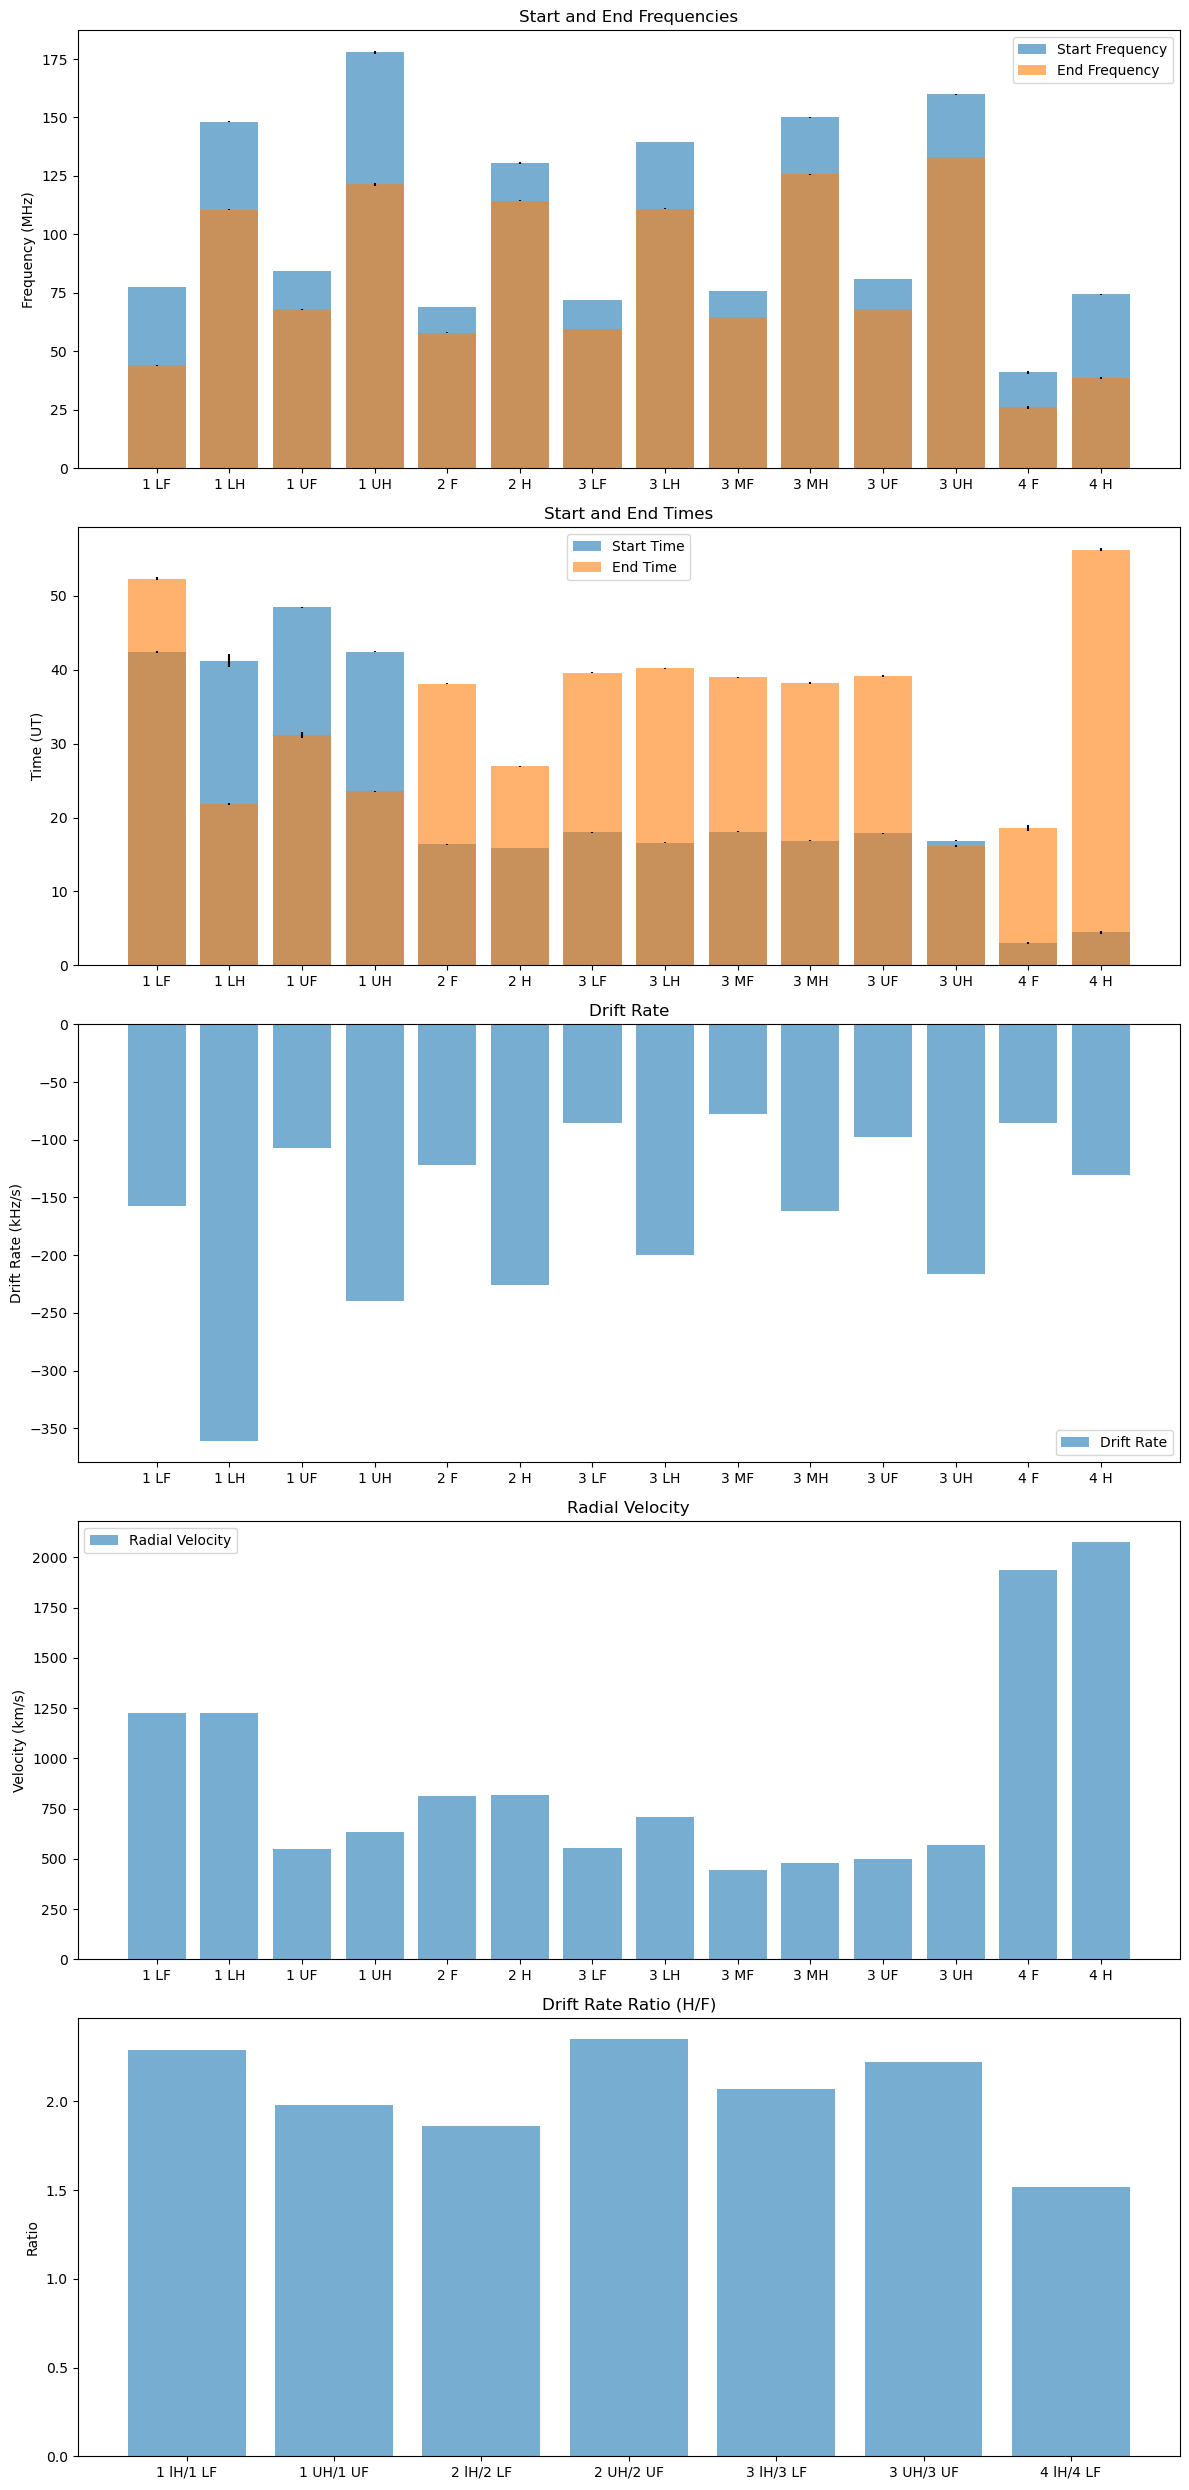

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Data from the table
bands = ['1 LF', '1 LH', '1 UF', '1 UH', '2 F', '2 H', '3 LF', '3 LH', '3 MF', '3 MH', '3 UF', '3 UH', '4 F', '4 H']

start_freq = np.array([77.61, 148.14, 84.28, 177.81, 68.90, 130.54, 71.80, 139.48, 75.86, 150.05, 80.99, 159.90, 41.07, 74.44])
end_freq = np.array([44.07, 110.55, 68.03, 121.39, 57.98, 114.50, 59.58, 111.05, 64.81, 125.63, 68.18, 133.10, 26.10, 38.49])

start_freq_err = np.array([0.10, 0.16, 0.11, 0.54, 0.05, 0.29, 0.02, 0.13, 0.05, 0.13, 0.14, 0.16, 0.61, 0.27])
end_freq_err = np.array([0.14, 0.11, 0.18, 0.51, 0.17, 0.38, 0.10, 0.18, 0.04, 0.17, 0.09, 0.19, 0.54, 0.43])

start_time = np.array([42.35, 41.22, 48.46, 42.47, 16.36, 15.85, 17.99, 16.62, 18.10, 16.85, 17.89, 16.87, 2.98, 4.44])
end_time = np.array([52.33, 21.81, 31.16, 23.54, 38.13, 26.93, 39.62, 40.23, 38.98, 38.22, 39.15, 16.15, 18.60, 56.26])
start_time_err = np.array([0.138, 0.903, 0.104, 0.088, 0.027, 0.031, 0.044, 0.044, 0.096, 0.053, 0.070, 0.044, 0.137, 0.230])
end_time_err = np.array([0.200, 0.160, 0.446, 0.107, 0.074, 0.084, 0.102, 0.059, 0.065, 0.115, 0.087, 0.105, 0.382, 0.202])

drift_rate = np.array([-157.48, -361.30, -107.42, -239.77, -121.64, -226.21, -85.04, -200.22, -77.88, -161.54, -97.43, -216.04, -85.85, -130.21])
radial_velocity = np.array([1227.51, 1224.16, 546.37, 632.60, 810.057, 816.65, 553.15, 709.25, 443.09, 480.89, 497.91, 568.12, 1939.38, 2075.31])
drift_rate_ratio = np.array([2.29, 1.98, 1.86, 2.35, 2.07, 2.22, 1.52])



fig, axes = plt.subplots(5, 1, figsize=(12, 25))

# Start and End Frequencies
axes[0].bar(bands, start_freq, yerr=start_freq_err, label='Start Frequency', alpha=0.6)
axes[0].bar(bands, end_freq, yerr=end_freq_err, label='End Frequency', alpha=0.6)
axes[0].set_ylabel('Frequency (MHz)')
axes[0].set_title('Start and End Frequencies')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=0)

# Start and End Times
axes[1].bar(bands, start_time, yerr=start_time_err, label='Start Time', alpha=0.6)
axes[1].bar(bands, end_time, yerr=end_time_err, label='End Time', alpha=0.6)
axes[1].set_ylabel('Time (UT)')
axes[1].set_title('Start and End Times')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=0)

# Drift Rate
axes[2].bar(bands, drift_rate, label='Drift Rate', alpha=0.6)
axes[2].set_ylabel('Drift Rate (kHz/s)')
axes[2].set_title('Drift Rate')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=0)

# Radial Velocity
axes[3].bar(bands, radial_velocity, label='Radial Velocity', alpha=0.6)
axes[3].set_ylabel('Velocity (km/s)')
axes[3].set_title('Radial Velocity')
axes[3].legend()
axes[3].tick_params(axis='x', rotation=0)

# Labels for the seven H/F bursts with custom names
labels = ['1 lH/1 LF', '1 UH/1 UF', '2 lH/2 LF', '2 UH/2 UF', '3 lH/3 LF', '3 UH/3 UF', '4 lH/4 LF']
# Positions for the 7 bars
tick_positions = np.arange(len(labels))  # [0, 1, 2, 3, 4, 5, 6]
axes[4].bar(tick_positions, drift_rate_ratio, label='Drift Rate Ratio', alpha=0.6)
axes[4].set_xticks(tick_positions)
axes[4].set_xticklabels(labels, rotation=0, ha='center')
axes[4].set_ylabel('Ratio')
axes[4].set_title('Drift Rate Ratio (H/F)')

plt.tight_layout()
plt.show()

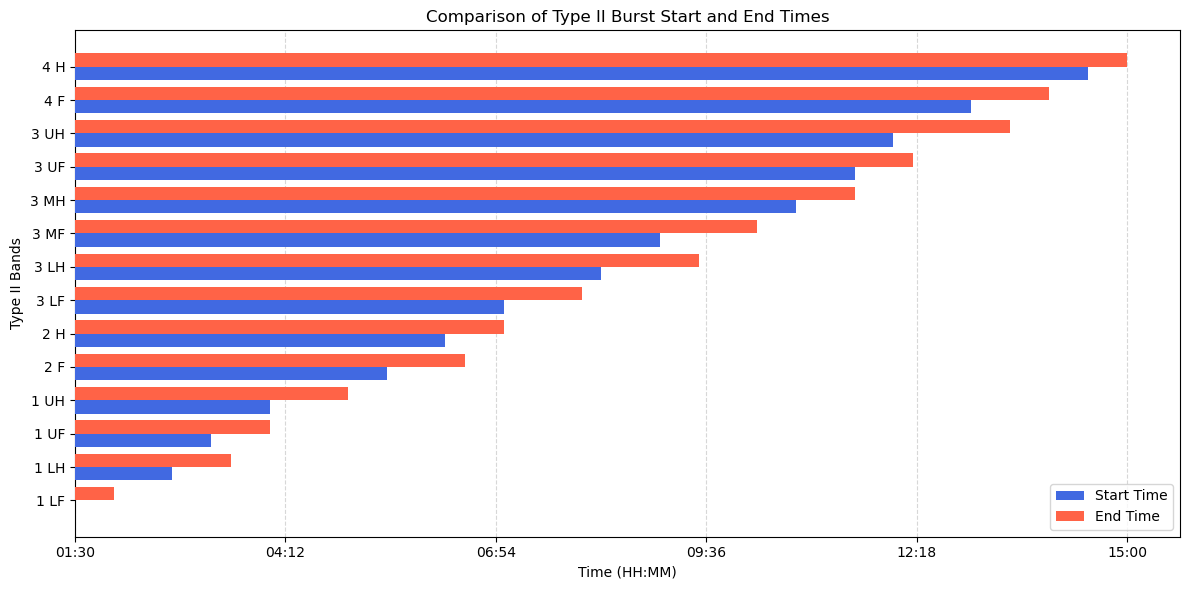

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime

# Data for start and end times (you can replace this with your actual data)
data = {
    'Band': ['1 LF', '1 LH', '1 UF', '1 UH', '2 F', '2 H', '3 LF', '3 LH', '3 MF', '3 MH', '3 UF', '3 UH', '4 F', '4 H'],
    'Start Time': ['01:30', '02:45', '03:15', '04:00', '05:30', '06:15', '07:00', '08:15', '09:00', '10:45', '11:30', '12:00', '13:00', '14:30'],
    'End Time': ['02:00', '03:30', '04:00', '05:00', '06:30', '07:00', '08:00', '09:30', '10:15', '11:30', '12:15', '13:30', '14:00', '15:00']
}

df = pd.DataFrame(data)

# Convert time strings to datetime objects
df['Start Time'] = pd.to_datetime(df['Start Time'], format='%H:%M')
df['End Time'] = pd.to_datetime(df['End Time'], format='%H:%M')

# Sorting for better visualization
df['Burst'] = df['Band'].str.extract(r'(\d+)').astype(int)
df['Type'] = df['Band'].str.extract(r'(LF|LH|UF|UH|F|H|MF|MH)')
df = df.sort_values(by=['Burst', 'Type'])

# Setting up bar height and positions
bar_height = 0.4
y_pos = np.arange(len(df))

# Create figure and plot
plt.figure(figsize=(12, 6))

# Plotting start and end times horizontally
plt.barh(y_pos - bar_height/2, (df['Start Time'] - df['Start Time'].min()).dt.total_seconds() / 3600, 
         bar_height, label='Start Time', color='royalblue', zorder=10)
plt.barh(y_pos + bar_height/2, (df['End Time'] - df['Start Time'].min()).dt.total_seconds() / 3600, 
         bar_height, label='End Time', color='tomato', zorder=10)

# Format the x-axis for HH:MM time format
plt.xlabel('Time (HH:MM)')
plt.ylabel('Type II Bands')
plt.title('Comparison of Type II Burst Start and End Times')

# Set the x-ticks to be in HH:MM format
start_time_min = df['Start Time'].min()
plt.xticks(np.linspace(0, (df['End Time'] - start_time_min).dt.total_seconds().max() / 3600, 6),
           [str((start_time_min + pd.Timedelta(hours=i)).strftime('%H:%M')) for i in np.linspace(0, 
           (df['End Time'] - start_time_min).dt.total_seconds().max() / 3600, 6)])

plt.yticks(y_pos, df['Band'])

plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()